<a href="https://colab.research.google.com/github/MrEplenier/deep-reinforcement-learning/blob/master/MountainCar_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modules

In [ ]:
# importation des modules nécessaires
import numpy as np
import random
import gym
from matplotlib import pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


## Accès à Drive

In [ ]:
# Permet de sauvegarder/charger les poids du réseau de neurones
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Environnement
Fonctions gym :
* **`gym.make()`** : charger le jeu


In [ ]:
# On charge l'environnement
game = 'MountainCar-v0'
env = gym.make(game)

# Permet de récupérer le nombre d'actions possible pour la voiture
nb_actions = env.action_space.n

# Permet de récupérer les dimensions de l'espace d'observation (x,y)
dim_observations = env.observation_space.shape[0]

print('Nombre d\'actions possibles : {}'.format(nb_actions))
print('Dimension des observations : {}'.format(dim_observations))

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Nombre d'actions possibles : 3
Dimension des observations : 2


## Test de l'environnement (actions aléatoires)  
Cette étape est facultative, elle permet de voir comment se comporte l'environnement.

Fonctions gym :
* **`env.reset()`** : réinitialiser le jeu (nouvelle partie)
* **`env.action_space.sample()`** : choisir une action aléatoire parmis l'ensemble des actions disponibles
* **`env.step(action)`** : effectuer dans le jeu l'action choisie et récupérer les informations suivantes :
  * La nouvelle observation (les nouvelles coordonnées de la voiture)
  * La récompense obtenue
  * Savoir si la partie est terminée




In [ ]:
env.reset()
score = 0

for i in range(300):
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)

  # Modélisation de la reward en fonction de la position de l'agent pour aider le modèle à s'entraîner 

  if observation[0] >= -0.5 and observation[0] < -0.3:
    reward += 10
  elif observation[0] >= -0.3 and observation[0] < 0.0:
    reward += 20
  elif observation[0] >= 0.0 and observation[0] < 0.3:
    reward += 30
  elif observation[0] >= -0.3 and observation[0] < 0.5:
    reward += 40
  elif observation[0] >= 0.5:
    reward += 50

  # On additionne les reward afin de se constituer un score
  score += reward
  print('Reward : {}, Score : {}, Done : {}, Observation : {}'.format(reward, score, done, observation))

  # Si le drapeau est atteint, on arrête la partie
  if done:
    break

Reward : -1.0, Score : -1.0, Done : False, Observation : [-0.52632163  0.00102813]
Reward : -1.0, Score : -2.0, Done : False, Observation : [-0.52527308  0.00104855]
Reward : -1.0, Score : -3.0, Done : False, Observation : [-5.25211967e-01  6.11102019e-05]
Reward : -1.0, Score : -4.0, Done : False, Observation : [-0.52413876  0.00107321]
Reward : -1.0, Score : -5.0, Done : False, Observation : [-5.24061499e-01  7.72589597e-05]
Reward : -1.0, Score : -6.0, Done : False, Observation : [-5.23980770e-01  8.07293857e-05]
Reward : -1.0, Score : -7.0, Done : False, Observation : [-5.23897175e-01  8.35943418e-05]
Reward : -1.0, Score : -8.0, Done : False, Observation : [-0.52481134 -0.00091417]
Reward : -1.0, Score : -9.0, Done : False, Observation : [-0.52671642 -0.00190507]
Reward : -1.0, Score : -10.0, Done : False, Observation : [-0.52959811 -0.00288169]
Reward : -1.0, Score : -11.0, Done : False, Observation : [-0.53243481 -0.0028367 ]
Reward : -1.0, Score : -12.0, Done : False, Observati

## Paramètres
* **`epsilon`** : taux initial d'actions aléatoires
* **`epsilon_min`** : taux final d'actions aléatoires
* **`epsilon_decay`** : coefficient multiplicatif de descente appliqué au pourcentage d’action aléatoires
* **`learning_rate`** : vitesse d'aprentissage
* **`discount_rate`** : facteur gamma de l’équation de Bellman pour donner moins d’importance aux récompenses des actions futures
* **`memory`** : mémoire utilisée pour stocker toutes les expériences accumulées
* **`batch_size`** : nombre de fois où nous fittons le réseau de neurones entre chaque partie

In [ ]:
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.999
learning_rate = 0.0025
discount_rate = 0.95
memory = deque(maxlen=1000000)
batch_size = 48

## Réseau de neuronnes

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim = dim_observations))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(nb_actions, activation = 'linear'))
model.compile(loss = 'mse', optimizer = Adam(lr = learning_rate))

# Permet d'afficher la structure du réseau de neurones
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


## Pré-entraînement de la mémoire
Etape nécessaire au commencement de l'entraînement du modèle.  
L'intérêt pratique de cette étape est détaillé dans le rapport. 

In [ ]:
for i in range(10):

  # Initialisation de l'environnement
  observation = env.reset().reshape([1, dim_observations])

  for i in range(1000):

    # Choisir une action
    if np.random.sample() < epsilon:
      action = env.action_space.sample()
    else:
      action = np.argmax(model.predict(observation)[0])

    # Effectuer l'action
    nouvelle_observation, reward, done, _ = env.step(action)

    # Mémoriser l'ancienne et la nouvelle observation puis la remplacer
    nouvelle_observation = nouvelle_observation.reshape([1, dim_observations])
    memory.append((observation, action, reward, done, nouvelle_observation))
    observation = nouvelle_observation

    if done:
      break

## Entraînement du modèle

#### Exploration vs Exploitation
* ***Exploration*** : actions aléatoires
* ***Exploitation*** : actions prédites par le modèle

Le paramètre **`epislon`** correspond au niveau d'exploration.

Au cours de l'entraînement du modèle, le niveau d'exploration diminue petit à petit, ce qui augmente le niveau d'exploitation.

Episode : 0/5000, Score : -158.0, Exploration : 100%








Episode : 1/5000, Score : -194.0, Exploration : 100%
Episode : 2/5000, Score : -84.0, Exploration : 100%
Episode : 3/5000, Score : -144.0, Exploration : 100%
Episode : 4/5000, Score : -94.0, Exploration : 100%
Episode : 5/5000, Score : -162.0, Exploration : 100%
Episode : 6/5000, Score : -114.0, Exploration : 99%
Episode : 7/5000, Score : -140.0, Exploration : 99%
Episode : 8/5000, Score : -44.0, Exploration : 99%
Episode : 9/5000, Score : -60.0, Exploration : 99%
Episode : 10/5000, Score : -200.0, Exploration : 99%
Episode : 11/5000, Score : -112.0, Exploration : 99%
Episode : 12/5000, Score : -188.0, Exploration : 99%
Episode : 13/5000, Score : -124.0, Exploration : 99%
Episode : 14/5000, Score : -166.0, Exploration : 99%
Episode : 15/5000, Score : -200.0, Exploration : 99%
Episode : 16/5000, Score : -150.0, Exploration : 98%
Episode : 17/5000, Score : -88.0, Exploration : 98%
Episode : 18/5000, Score : -156.0, Exploration 

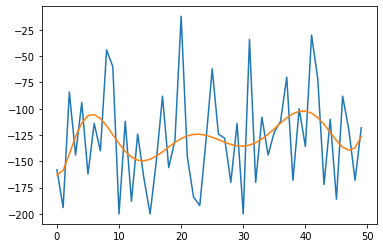

Episode : 50/5000, Score : -86.0, Exploration : 95%
Episode : 51/5000, Score : -200.0, Exploration : 95%
Episode : 52/5000, Score : -102.0, Exploration : 95%
Episode : 53/5000, Score : -50.0, Exploration : 95%
Episode : 54/5000, Score : -200.0, Exploration : 95%
Episode : 55/5000, Score : -142.0, Exploration : 95%
Episode : 56/5000, Score : -126.0, Exploration : 95%
Episode : 57/5000, Score : -168.0, Exploration : 94%
Episode : 58/5000, Score : -104.0, Exploration : 94%
Episode : 59/5000, Score : -90.0, Exploration : 94%
Episode : 60/5000, Score : -198.0, Exploration : 94%
Episode : 61/5000, Score : -84.0, Exploration : 94%
Episode : 62/5000, Score : -156.0, Exploration : 94%
Episode : 63/5000, Score : -36.0, Exploration : 94%
Episode : 64/5000, Score : -170.0, Exploration : 94%
Episode : 65/5000, Score : -70.0, Exploration : 94%
Episode : 66/5000, Score : -50.0, Exploration : 94%
Episode : 67/5000, Score : -156.0, Exploration : 94%
Episode : 68/5000, Score : -80.0, Exploration : 93%
E

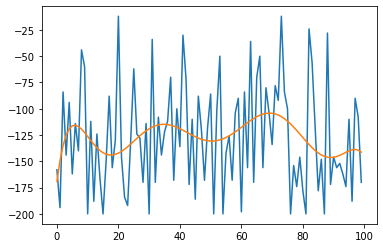

Episode : 100/5000, Score : -48.0, Exploration : 90%
Episode : 101/5000, Score : -70.0, Exploration : 90%
Episode : 102/5000, Score : -72.0, Exploration : 90%
Episode : 103/5000, Score : -156.0, Exploration : 90%
Episode : 104/5000, Score : -58.0, Exploration : 90%
Episode : 105/5000, Score : -50.0, Exploration : 90%
Episode : 106/5000, Score : -86.0, Exploration : 90%
Episode : 107/5000, Score : -158.0, Exploration : 90%
Episode : 108/5000, Score : -72.0, Exploration : 90%
Episode : 109/5000, Score : -62.0, Exploration : 90%
Episode : 110/5000, Score : -102.0, Exploration : 90%
Episode : 111/5000, Score : -170.0, Exploration : 89%
Episode : 112/5000, Score : -76.0, Exploration : 89%
Episode : 113/5000, Score : 42.0, Exploration : 89%
Episode : 114/5000, Score : -100.0, Exploration : 89%
Episode : 115/5000, Score : -124.0, Exploration : 89%
Episode : 116/5000, Score : -46.0, Exploration : 89%
Episode : 117/5000, Score : -98.0, Exploration : 89%
Episode : 118/5000, Score : -200.0, Explo

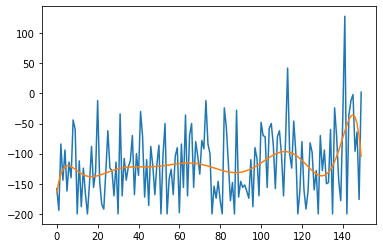

Episode : 150/5000, Score : -54.0, Exploration : 86%
Episode : 151/5000, Score : -180.0, Exploration : 86%
Episode : 152/5000, Score : -52.0, Exploration : 86%
Episode : 153/5000, Score : 46.0, Exploration : 86%
Episode : 154/5000, Score : -200.0, Exploration : 86%
Episode : 155/5000, Score : -96.0, Exploration : 86%
Episode : 156/5000, Score : -132.0, Exploration : 86%
Episode : 157/5000, Score : -58.0, Exploration : 85%
Episode : 158/5000, Score : -58.0, Exploration : 85%
Episode : 159/5000, Score : -146.0, Exploration : 85%
Episode : 160/5000, Score : -146.0, Exploration : 85%
Episode : 161/5000, Score : -94.0, Exploration : 85%
Episode : 162/5000, Score : -98.0, Exploration : 85%
Episode : 163/5000, Score : -66.0, Exploration : 85%
Episode : 164/5000, Score : -200.0, Exploration : 85%
Episode : 165/5000, Score : 42.0, Exploration : 85%
Episode : 166/5000, Score : -28.0, Exploration : 85%
Episode : 167/5000, Score : -164.0, Exploration : 85%
Episode : 168/5000, Score : -98.0, Explor

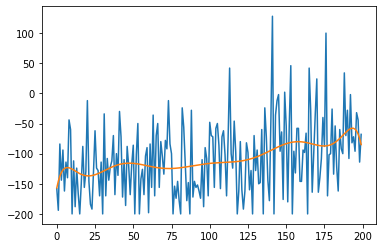

Episode : 200/5000, Score : -28.0, Exploration : 82%
Episode : 201/5000, Score : -126.0, Exploration : 82%
Episode : 202/5000, Score : -138.0, Exploration : 82%
Episode : 203/5000, Score : -78.0, Exploration : 82%
Episode : 204/5000, Score : -2.0, Exploration : 82%
Episode : 205/5000, Score : -82.0, Exploration : 81%
Episode : 206/5000, Score : -6.0, Exploration : 81%
Episode : 207/5000, Score : -86.0, Exploration : 81%
Episode : 208/5000, Score : -200.0, Exploration : 81%
Episode : 209/5000, Score : 122.0, Exploration : 81%
Episode : 210/5000, Score : -56.0, Exploration : 81%
Episode : 211/5000, Score : -112.0, Exploration : 81%
Episode : 212/5000, Score : -56.0, Exploration : 81%
Episode : 213/5000, Score : -184.0, Exploration : 81%
Episode : 214/5000, Score : -120.0, Exploration : 81%
Episode : 215/5000, Score : -26.0, Exploration : 81%
Episode : 216/5000, Score : -20.0, Exploration : 81%
Episode : 217/5000, Score : -112.0, Exploration : 80%
Episode : 218/5000, Score : 156.0, Explor

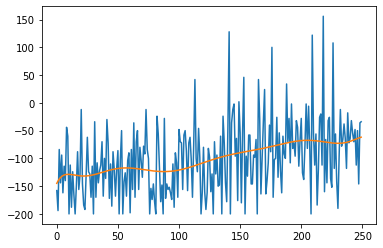

Episode : 250/5000, Score : -166.0, Exploration : 78%
Episode : 251/5000, Score : -60.0, Exploration : 78%
Episode : 252/5000, Score : -200.0, Exploration : 78%
Episode : 253/5000, Score : -56.0, Exploration : 78%
Episode : 254/5000, Score : -142.0, Exploration : 78%
Episode : 255/5000, Score : -142.0, Exploration : 77%
Episode : 256/5000, Score : -44.0, Exploration : 77%
Episode : 257/5000, Score : -20.0, Exploration : 77%
Episode : 258/5000, Score : 18.0, Exploration : 77%
Episode : 259/5000, Score : -70.0, Exploration : 77%
Episode : 260/5000, Score : -152.0, Exploration : 77%
Episode : 261/5000, Score : 26.0, Exploration : 77%
Episode : 262/5000, Score : -82.0, Exploration : 77%
Episode : 263/5000, Score : -18.0, Exploration : 77%
Episode : 264/5000, Score : -84.0, Exploration : 77%
Episode : 265/5000, Score : -136.0, Exploration : 77%
Episode : 266/5000, Score : -16.0, Exploration : 77%
Episode : 267/5000, Score : -162.0, Exploration : 77%
Episode : 268/5000, Score : -80.0, Explor

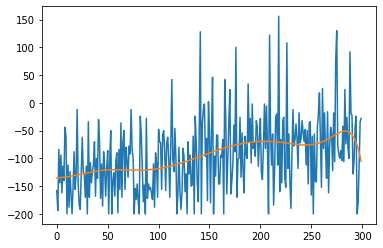

Episode : 300/5000, Score : -24.0, Exploration : 74%
Episode : 301/5000, Score : -32.0, Exploration : 74%
Episode : 302/5000, Score : -144.0, Exploration : 74%
Episode : 303/5000, Score : 0.0, Exploration : 74%
Episode : 304/5000, Score : -20.0, Exploration : 74%
Episode : 305/5000, Score : -38.0, Exploration : 74%
Episode : 306/5000, Score : -80.0, Exploration : 74%
Episode : 307/5000, Score : -64.0, Exploration : 74%
Episode : 308/5000, Score : -40.0, Exploration : 73%
Episode : 309/5000, Score : -12.0, Exploration : 73%
Episode : 310/5000, Score : -4.0, Exploration : 73%
Episode : 311/5000, Score : -6.0, Exploration : 73%
Episode : 312/5000, Score : -186.0, Exploration : 73%
Episode : 313/5000, Score : -32.0, Exploration : 73%
Episode : 314/5000, Score : -6.0, Exploration : 73%
Episode : 315/5000, Score : -122.0, Exploration : 73%
Episode : 316/5000, Score : 2.0, Exploration : 73%
Episode : 317/5000, Score : 74.0, Exploration : 73%
Episode : 318/5000, Score : -92.0, Exploration : 73

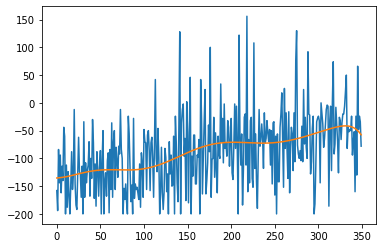

Episode : 350/5000, Score : -44.0, Exploration : 70%
Episode : 351/5000, Score : -132.0, Exploration : 70%
Episode : 352/5000, Score : -16.0, Exploration : 70%
Episode : 353/5000, Score : -22.0, Exploration : 70%
Episode : 354/5000, Score : -58.0, Exploration : 70%
Episode : 355/5000, Score : -44.0, Exploration : 70%
Episode : 356/5000, Score : -92.0, Exploration : 70%
Episode : 357/5000, Score : 58.0, Exploration : 70%
Episode : 358/5000, Score : 0.0, Exploration : 70%
Episode : 359/5000, Score : -90.0, Exploration : 70%
Episode : 360/5000, Score : -10.0, Exploration : 70%
Episode : 361/5000, Score : -80.0, Exploration : 70%
Episode : 362/5000, Score : -22.0, Exploration : 70%
Episode : 363/5000, Score : -26.0, Exploration : 70%
Episode : 364/5000, Score : -10.0, Exploration : 69%
Episode : 365/5000, Score : -24.0, Exploration : 69%
Episode : 366/5000, Score : -16.0, Exploration : 69%
Episode : 367/5000, Score : -16.0, Exploration : 69%
Episode : 368/5000, Score : -26.0, Exploration :

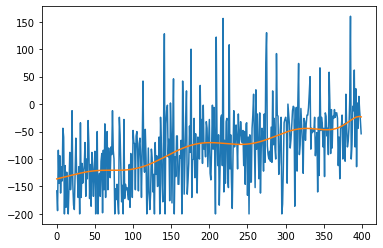

Episode : 400/5000, Score : -10.0, Exploration : 67%
Episode : 401/5000, Score : -68.0, Exploration : 67%
Episode : 402/5000, Score : 0.0, Exploration : 67%
Episode : 403/5000, Score : 136.0, Exploration : 67%
Episode : 404/5000, Score : 16.0, Exploration : 67%
Episode : 405/5000, Score : -22.0, Exploration : 67%
Episode : 406/5000, Score : -52.0, Exploration : 67%
Episode : 407/5000, Score : 14.0, Exploration : 67%
Episode : 408/5000, Score : -6.0, Exploration : 66%
Episode : 409/5000, Score : -14.0, Exploration : 66%
Episode : 410/5000, Score : -84.0, Exploration : 66%
Episode : 411/5000, Score : 0.0, Exploration : 66%
Episode : 412/5000, Score : 146.0, Exploration : 66%
Episode : 413/5000, Score : -100.0, Exploration : 66%
Episode : 414/5000, Score : -42.0, Exploration : 66%
Episode : 415/5000, Score : -4.0, Exploration : 66%
Episode : 416/5000, Score : -20.0, Exploration : 66%
Episode : 417/5000, Score : -6.0, Exploration : 66%
Episode : 418/5000, Score : 16.0, Exploration : 66%
Ep

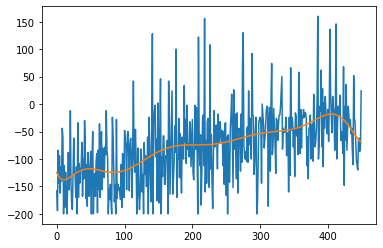

Episode : 450/5000, Score : -12.0, Exploration : 64%
Episode : 451/5000, Score : -76.0, Exploration : 64%
Episode : 452/5000, Score : -28.0, Exploration : 64%
Episode : 453/5000, Score : -4.0, Exploration : 64%
Episode : 454/5000, Score : 40.0, Exploration : 63%
Episode : 455/5000, Score : 6.0, Exploration : 63%
Episode : 456/5000, Score : -10.0, Exploration : 63%
Episode : 457/5000, Score : -32.0, Exploration : 63%
Episode : 458/5000, Score : -48.0, Exploration : 63%
Episode : 459/5000, Score : -58.0, Exploration : 63%
Episode : 460/5000, Score : -26.0, Exploration : 63%
Episode : 461/5000, Score : -28.0, Exploration : 63%
Episode : 462/5000, Score : -28.0, Exploration : 63%
Episode : 463/5000, Score : -22.0, Exploration : 63%
Episode : 464/5000, Score : -66.0, Exploration : 63%
Episode : 465/5000, Score : -40.0, Exploration : 63%
Episode : 466/5000, Score : -96.0, Exploration : 63%
Episode : 467/5000, Score : -14.0, Exploration : 63%
Episode : 468/5000, Score : -42.0, Exploration : 6

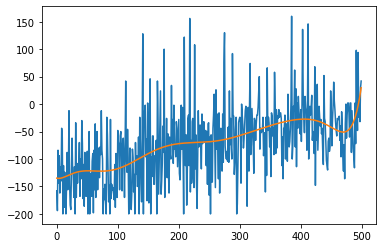

Episode : 500/5000, Score : -138.0, Exploration : 61%
Episode : 501/5000, Score : -20.0, Exploration : 61%
Episode : 502/5000, Score : -94.0, Exploration : 61%
Episode : 503/5000, Score : 328.0, Exploration : 60%
Episode : 504/5000, Score : 84.0, Exploration : 60%
Episode : 505/5000, Score : -66.0, Exploration : 60%
Episode : 506/5000, Score : -52.0, Exploration : 60%
Episode : 507/5000, Score : -46.0, Exploration : 60%
Episode : 508/5000, Score : -112.0, Exploration : 60%
Episode : 509/5000, Score : -24.0, Exploration : 60%
Episode : 510/5000, Score : -34.0, Exploration : 60%
Episode : 511/5000, Score : 176.0, Exploration : 60%
Episode : 512/5000, Score : -120.0, Exploration : 60%
Episode : 513/5000, Score : -4.0, Exploration : 60%
Episode : 514/5000, Score : -62.0, Exploration : 60%
Episode : 515/5000, Score : -132.0, Exploration : 60%
Episode : 516/5000, Score : 8.0, Exploration : 60%
Episode : 517/5000, Score : -36.0, Exploration : 60%
Episode : 518/5000, Score : 54.0, Exploration 

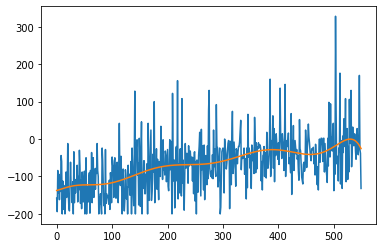

Episode : 550/5000, Score : -4.0, Exploration : 58%
Episode : 551/5000, Score : -4.0, Exploration : 58%
Episode : 552/5000, Score : -10.0, Exploration : 58%
Episode : 553/5000, Score : -28.0, Exploration : 58%
Episode : 554/5000, Score : -14.0, Exploration : 57%
Episode : 555/5000, Score : -14.0, Exploration : 57%
Episode : 556/5000, Score : 2.0, Exploration : 57%
Episode : 557/5000, Score : -90.0, Exploration : 57%
Episode : 558/5000, Score : -16.0, Exploration : 57%
Episode : 559/5000, Score : -44.0, Exploration : 57%
Episode : 560/5000, Score : 18.0, Exploration : 57%
Episode : 561/5000, Score : -26.0, Exploration : 57%
Episode : 562/5000, Score : 0.0, Exploration : 57%
Episode : 563/5000, Score : 146.0, Exploration : 57%
Episode : 564/5000, Score : -42.0, Exploration : 57%
Episode : 565/5000, Score : -2.0, Exploration : 57%
Episode : 566/5000, Score : -16.0, Exploration : 57%
Episode : 567/5000, Score : 102.0, Exploration : 57%
Episode : 568/5000, Score : -44.0, Exploration : 57%
E

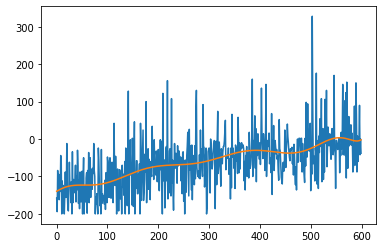

Episode : 600/5000, Score : -26.0, Exploration : 55%
Episode : 601/5000, Score : -6.0, Exploration : 55%
Episode : 602/5000, Score : 74.0, Exploration : 55%
Episode : 603/5000, Score : -64.0, Exploration : 55%
Episode : 604/5000, Score : -18.0, Exploration : 55%
Episode : 605/5000, Score : -68.0, Exploration : 55%
Episode : 606/5000, Score : 70.0, Exploration : 55%
Episode : 607/5000, Score : -20.0, Exploration : 54%
Episode : 608/5000, Score : -8.0, Exploration : 54%
Episode : 609/5000, Score : -44.0, Exploration : 54%
Episode : 610/5000, Score : -42.0, Exploration : 54%
Episode : 611/5000, Score : -22.0, Exploration : 54%
Episode : 612/5000, Score : 26.0, Exploration : 54%
Episode : 613/5000, Score : -2.0, Exploration : 54%
Episode : 614/5000, Score : 52.0, Exploration : 54%
Episode : 615/5000, Score : 10.0, Exploration : 54%
Episode : 616/5000, Score : 78.0, Exploration : 54%
Episode : 617/5000, Score : -6.0, Exploration : 54%
Episode : 618/5000, Score : -38.0, Exploration : 54%
Epi

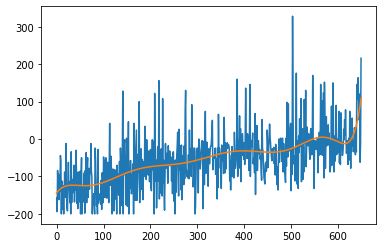

Episode : 650/5000, Score : -24.0, Exploration : 52%
Episode : 651/5000, Score : 98.0, Exploration : 52%
Episode : 652/5000, Score : 222.0, Exploration : 52%
Episode : 653/5000, Score : 40.0, Exploration : 52%
Episode : 654/5000, Score : 164.0, Exploration : 52%
Episode : 655/5000, Score : 26.0, Exploration : 52%
Episode : 656/5000, Score : 46.0, Exploration : 52%
Episode : 657/5000, Score : 10.0, Exploration : 52%
Episode : 658/5000, Score : -12.0, Exploration : 52%
Episode : 659/5000, Score : 34.0, Exploration : 52%
Episode : 660/5000, Score : -118.0, Exploration : 52%
Episode : 661/5000, Score : 34.0, Exploration : 52%
Episode : 662/5000, Score : 62.0, Exploration : 52%
Episode : 663/5000, Score : -18.0, Exploration : 52%
Episode : 664/5000, Score : -62.0, Exploration : 51%
Episode : 665/5000, Score : 26.0, Exploration : 51%
Episode : 666/5000, Score : -50.0, Exploration : 51%
Episode : 667/5000, Score : 359.0, Exploration : 51%
Episode : 668/5000, Score : 24.0, Exploration : 51%
Ep

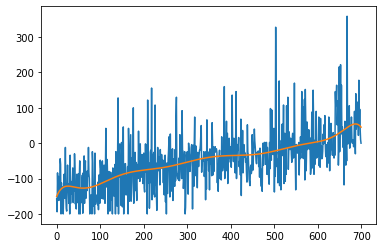

Episode : 700/5000, Score : -16.0, Exploration : 50%
Episode : 701/5000, Score : -34.0, Exploration : 50%
Episode : 702/5000, Score : 18.0, Exploration : 50%
Episode : 703/5000, Score : -4.0, Exploration : 49%
Episode : 704/5000, Score : 20.0, Exploration : 49%
Episode : 705/5000, Score : -28.0, Exploration : 49%
Episode : 706/5000, Score : 250.0, Exploration : 49%
Episode : 707/5000, Score : -12.0, Exploration : 49%
Episode : 708/5000, Score : -62.0, Exploration : 49%
Episode : 709/5000, Score : -72.0, Exploration : 49%
Episode : 710/5000, Score : 407.0, Exploration : 49%
Episode : 711/5000, Score : 188.0, Exploration : 49%
Episode : 712/5000, Score : 34.0, Exploration : 49%
Episode : 713/5000, Score : 24.0, Exploration : 49%
Episode : 714/5000, Score : 10.0, Exploration : 49%
Episode : 715/5000, Score : 108.0, Exploration : 49%
Episode : 716/5000, Score : -32.0, Exploration : 49%
Episode : 717/5000, Score : 158.0, Exploration : 49%
Episode : 718/5000, Score : 24.0, Exploration : 49%


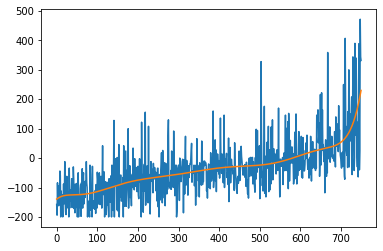

Episode : 750/5000, Score : 256.0, Exploration : 47%
Episode : 751/5000, Score : 369.0, Exploration : 47%
Episode : 752/5000, Score : 166.0, Exploration : 47%
Episode : 753/5000, Score : 196.0, Exploration : 47%
Episode : 754/5000, Score : 371.0, Exploration : 47%
Episode : 755/5000, Score : -6.0, Exploration : 47%
Episode : 756/5000, Score : -78.0, Exploration : 47%
Episode : 757/5000, Score : 162.0, Exploration : 47%
Episode : 758/5000, Score : 118.0, Exploration : 47%
Episode : 759/5000, Score : 202.0, Exploration : 47%
Episode : 760/5000, Score : 124.0, Exploration : 47%
Episode : 761/5000, Score : 20.0, Exploration : 47%
Episode : 762/5000, Score : -70.0, Exploration : 47%
Episode : 763/5000, Score : 242.0, Exploration : 47%
Episode : 764/5000, Score : -24.0, Exploration : 47%
Episode : 765/5000, Score : 24.0, Exploration : 47%
Episode : 766/5000, Score : 322.0, Exploration : 46%
Episode : 767/5000, Score : -48.0, Exploration : 46%
Episode : 768/5000, Score : 200.0, Exploration : 

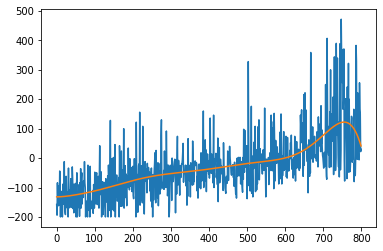

Episode : 800/5000, Score : 379.0, Exploration : 45%
Episode : 801/5000, Score : 372.0, Exploration : 45%
Episode : 802/5000, Score : 325.0, Exploration : 45%
Episode : 803/5000, Score : 144.0, Exploration : 45%
Episode : 804/5000, Score : 38.0, Exploration : 45%
Episode : 805/5000, Score : 162.0, Exploration : 45%
Episode : 806/5000, Score : 78.0, Exploration : 45%
Episode : 807/5000, Score : 162.0, Exploration : 45%
Episode : 808/5000, Score : 16.0, Exploration : 45%
Episode : 809/5000, Score : -2.0, Exploration : 45%
Episode : 810/5000, Score : -32.0, Exploration : 44%
Episode : 811/5000, Score : 78.0, Exploration : 44%
Episode : 812/5000, Score : 24.0, Exploration : 44%
Episode : 813/5000, Score : 198.0, Exploration : 44%
Episode : 814/5000, Score : 18.0, Exploration : 44%
Episode : 815/5000, Score : 252.0, Exploration : 44%
Episode : 816/5000, Score : 202.0, Exploration : 44%
Episode : 817/5000, Score : 342.0, Exploration : 44%
Episode : 818/5000, Score : 286.0, Exploration : 44%


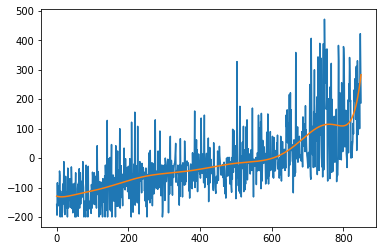

Episode : 850/5000, Score : 385.0, Exploration : 43%
Episode : 851/5000, Score : 233.0, Exploration : 43%
Episode : 852/5000, Score : -4.0, Exploration : 43%
Episode : 853/5000, Score : 16.0, Exploration : 43%
Episode : 854/5000, Score : 94.0, Exploration : 43%
Episode : 855/5000, Score : 30.0, Exploration : 43%
Episode : 856/5000, Score : 230.0, Exploration : 42%
Episode : 857/5000, Score : -6.0, Exploration : 42%
Episode : 858/5000, Score : 32.0, Exploration : 42%
Episode : 859/5000, Score : 12.0, Exploration : 42%
Episode : 860/5000, Score : 332.0, Exploration : 42%
Episode : 861/5000, Score : 294.0, Exploration : 42%
Episode : 862/5000, Score : 0.0, Exploration : 42%
Episode : 863/5000, Score : 372.0, Exploration : 42%
Episode : 864/5000, Score : 120.0, Exploration : 42%
Episode : 865/5000, Score : 32.0, Exploration : 42%
Episode : 866/5000, Score : 74.0, Exploration : 42%
Episode : 867/5000, Score : 248.0, Exploration : 42%
Episode : 868/5000, Score : 395.0, Exploration : 42%
Epis

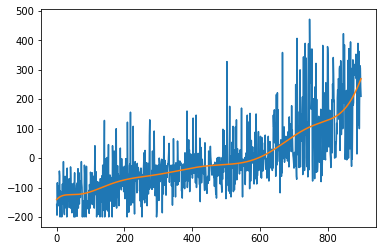

Episode : 900/5000, Score : 293.0, Exploration : 41%
Episode : 901/5000, Score : 44.0, Exploration : 41%
Episode : 902/5000, Score : 216.0, Exploration : 41%
Episode : 903/5000, Score : 329.0, Exploration : 41%
Episode : 904/5000, Score : 24.0, Exploration : 40%
Episode : 905/5000, Score : 312.0, Exploration : 40%
Episode : 906/5000, Score : 328.0, Exploration : 40%
Episode : 907/5000, Score : 16.0, Exploration : 40%
Episode : 908/5000, Score : 18.0, Exploration : 40%
Episode : 909/5000, Score : 295.0, Exploration : 40%
Episode : 910/5000, Score : -34.0, Exploration : 40%
Episode : 911/5000, Score : 20.0, Exploration : 40%
Episode : 912/5000, Score : 60.0, Exploration : 40%
Episode : 913/5000, Score : 311.0, Exploration : 40%
Episode : 914/5000, Score : 38.0, Exploration : 40%
Episode : 915/5000, Score : 60.0, Exploration : 40%
Episode : 916/5000, Score : 240.0, Exploration : 40%
Episode : 917/5000, Score : 56.0, Exploration : 40%
Episode : 918/5000, Score : 44.0, Exploration : 40%
Epi

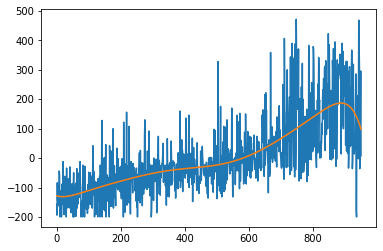

Episode : 950/5000, Score : 36.0, Exploration : 39%
Episode : 951/5000, Score : 210.0, Exploration : 39%
Episode : 952/5000, Score : 308.0, Exploration : 39%
Episode : 953/5000, Score : 30.0, Exploration : 39%
Episode : 954/5000, Score : 32.0, Exploration : 39%
Episode : 955/5000, Score : 210.0, Exploration : 38%
Episode : 956/5000, Score : 38.0, Exploration : 38%
Episode : 957/5000, Score : -8.0, Exploration : 38%
Episode : 958/5000, Score : 8.0, Exploration : 38%
Episode : 959/5000, Score : 110.0, Exploration : 38%
Episode : 960/5000, Score : -12.0, Exploration : 38%
Episode : 961/5000, Score : 20.0, Exploration : 38%
Episode : 962/5000, Score : 28.0, Exploration : 38%
Episode : 963/5000, Score : 110.0, Exploration : 38%
Episode : 964/5000, Score : 28.0, Exploration : 38%
Episode : 965/5000, Score : 22.0, Exploration : 38%
Episode : 966/5000, Score : 232.0, Exploration : 38%
Episode : 967/5000, Score : 50.0, Exploration : 38%
Episode : 968/5000, Score : 12.0, Exploration : 38%
Episod

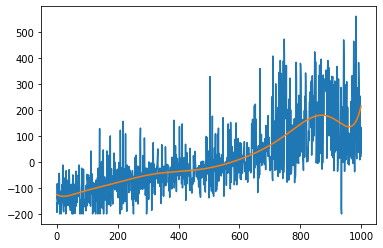

Episode : 1000/5000, Score : 357.0, Exploration : 37%
Episode : 1001/5000, Score : 320.0, Exploration : 37%
Episode : 1002/5000, Score : 315.0, Exploration : 37%
Episode : 1003/5000, Score : 52.0, Exploration : 37%
Episode : 1004/5000, Score : 267.0, Exploration : 37%
Episode : 1005/5000, Score : 372.0, Exploration : 37%
Episode : 1006/5000, Score : 36.0, Exploration : 37%
Episode : 1007/5000, Score : 66.0, Exploration : 37%
Episode : 1008/5000, Score : 246.0, Exploration : 36%
Episode : 1009/5000, Score : 46.0, Exploration : 36%
Episode : 1010/5000, Score : 228.0, Exploration : 36%
Episode : 1011/5000, Score : 40.0, Exploration : 36%
Episode : 1012/5000, Score : 222.0, Exploration : 36%
Episode : 1013/5000, Score : 336.0, Exploration : 36%
Episode : 1014/5000, Score : 379.0, Exploration : 36%
Episode : 1015/5000, Score : 268.0, Exploration : 36%
Episode : 1016/5000, Score : 336.0, Exploration : 36%
Episode : 1017/5000, Score : 198.0, Exploration : 36%
Episode : 1018/5000, Score : 359.

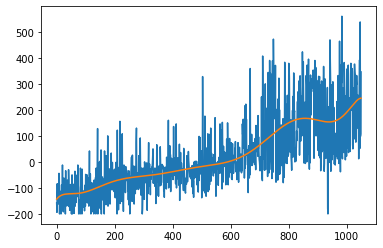

Episode : 1050/5000, Score : 322.0, Exploration : 35%
Episode : 1051/5000, Score : 280.0, Exploration : 35%
Episode : 1052/5000, Score : 546.0, Exploration : 35%
Episode : 1053/5000, Score : 456.0, Exploration : 35%
Episode : 1054/5000, Score : 368.0, Exploration : 35%
Episode : 1055/5000, Score : 24.0, Exploration : 35%
Episode : 1056/5000, Score : 104.0, Exploration : 35%
Episode : 1057/5000, Score : 326.0, Exploration : 35%
Episode : 1058/5000, Score : 326.0, Exploration : 35%
Episode : 1059/5000, Score : 302.0, Exploration : 35%
Episode : 1060/5000, Score : 368.0, Exploration : 35%
Episode : 1061/5000, Score : 444.0, Exploration : 35%
Episode : 1062/5000, Score : 256.0, Exploration : 35%
Episode : 1063/5000, Score : 421.0, Exploration : 35%
Episode : 1064/5000, Score : 194.0, Exploration : 34%
Episode : 1065/5000, Score : 16.0, Exploration : 34%
Episode : 1066/5000, Score : 102.0, Exploration : 34%
Episode : 1067/5000, Score : 20.0, Exploration : 34%
Episode : 1068/5000, Score : 19

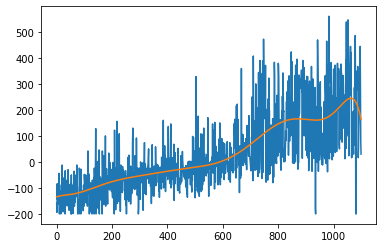

Episode : 1100/5000, Score : 24.0, Exploration : 33%
Episode : 1101/5000, Score : 14.0, Exploration : 33%
Episode : 1102/5000, Score : 18.0, Exploration : 33%
Episode : 1103/5000, Score : 152.0, Exploration : 33%
Episode : 1104/5000, Score : 18.0, Exploration : 33%
Episode : 1105/5000, Score : 198.0, Exploration : 33%
Episode : 1106/5000, Score : 198.0, Exploration : 33%
Episode : 1107/5000, Score : 16.0, Exploration : 33%
Episode : 1108/5000, Score : 84.0, Exploration : 33%
Episode : 1109/5000, Score : 270.0, Exploration : 33%
Episode : 1110/5000, Score : 294.0, Exploration : 33%
Episode : 1111/5000, Score : 124.0, Exploration : 33%
Episode : 1112/5000, Score : 208.0, Exploration : 33%
Episode : 1113/5000, Score : 352.0, Exploration : 33%
Episode : 1114/5000, Score : 302.0, Exploration : 33%
Episode : 1115/5000, Score : 337.0, Exploration : 33%
Episode : 1116/5000, Score : 338.0, Exploration : 33%
Episode : 1117/5000, Score : 333.0, Exploration : 33%
Episode : 1118/5000, Score : 244.0

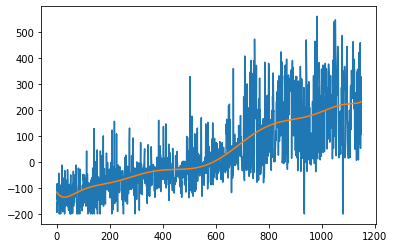

Episode : 1150/5000, Score : 327.0, Exploration : 32%
Episode : 1151/5000, Score : 422.0, Exploration : 32%
Episode : 1152/5000, Score : 2.0, Exploration : 32%
Episode : 1153/5000, Score : 362.0, Exploration : 32%
Episode : 1154/5000, Score : 106.0, Exploration : 32%
Episode : 1155/5000, Score : 322.0, Exploration : 31%
Episode : 1156/5000, Score : 373.0, Exploration : 31%
Episode : 1157/5000, Score : 293.0, Exploration : 31%
Episode : 1158/5000, Score : 168.0, Exploration : 31%
Episode : 1159/5000, Score : 150.0, Exploration : 31%
Episode : 1160/5000, Score : 456.0, Exploration : 31%
Episode : 1161/5000, Score : -200.0, Exploration : 31%
Episode : 1162/5000, Score : 341.0, Exploration : 31%
Episode : 1163/5000, Score : -4.0, Exploration : 31%
Episode : 1164/5000, Score : -200.0, Exploration : 31%
Episode : 1165/5000, Score : -200.0, Exploration : 31%
Episode : 1166/5000, Score : -200.0, Exploration : 31%
Episode : 1167/5000, Score : -68.0, Exploration : 31%
Episode : 1168/5000, Score 

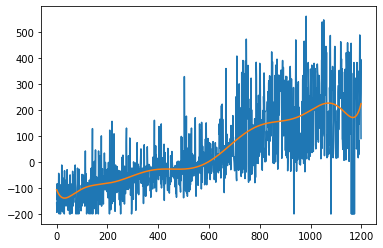

Episode : 1200/5000, Score : 154.0, Exploration : 30%
Episode : 1201/5000, Score : 212.0, Exploration : 30%
Episode : 1202/5000, Score : -38.0, Exploration : 30%
Episode : 1203/5000, Score : 254.0, Exploration : 30%
Episode : 1204/5000, Score : 368.0, Exploration : 30%
Episode : 1205/5000, Score : 316.0, Exploration : 30%
Episode : 1206/5000, Score : 398.0, Exploration : 30%
Episode : 1207/5000, Score : 334.0, Exploration : 30%
Episode : 1208/5000, Score : 446.0, Exploration : 30%
Episode : 1209/5000, Score : 353.0, Exploration : 30%
Episode : 1210/5000, Score : 418.0, Exploration : 30%
Episode : 1211/5000, Score : 400.0, Exploration : 30%
Episode : 1212/5000, Score : 343.0, Exploration : 30%
Episode : 1213/5000, Score : 78.0, Exploration : 30%
Episode : 1214/5000, Score : 222.0, Exploration : 30%
Episode : 1215/5000, Score : 312.0, Exploration : 30%
Episode : 1216/5000, Score : 385.0, Exploration : 30%
Episode : 1217/5000, Score : 353.0, Exploration : 30%
Episode : 1218/5000, Score : 

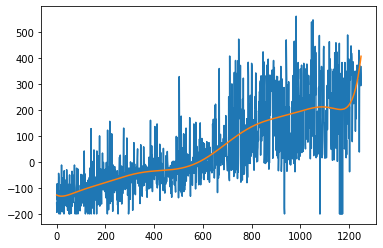

Episode : 1250/5000, Score : 356.0, Exploration : 29%
Episode : 1251/5000, Score : 210.0, Exploration : 29%
Episode : 1252/5000, Score : 354.0, Exploration : 29%
Episode : 1253/5000, Score : -152.0, Exploration : 29%
Episode : 1254/5000, Score : -154.0, Exploration : 29%
Episode : 1255/5000, Score : 46.0, Exploration : 28%
Episode : 1256/5000, Score : -98.0, Exploration : 28%
Episode : 1257/5000, Score : -122.0, Exploration : 28%
Episode : 1258/5000, Score : 60.0, Exploration : 28%
Episode : 1259/5000, Score : -200.0, Exploration : 28%
Episode : 1260/5000, Score : -132.0, Exploration : 28%
Episode : 1261/5000, Score : -22.0, Exploration : 28%
Episode : 1262/5000, Score : 476.0, Exploration : 28%
Episode : 1263/5000, Score : 443.0, Exploration : 28%
Episode : 1264/5000, Score : 150.0, Exploration : 28%
Episode : 1265/5000, Score : 446.0, Exploration : 28%
Episode : 1266/5000, Score : 110.0, Exploration : 28%
Episode : 1267/5000, Score : 212.0, Exploration : 28%
Episode : 1268/5000, Scor

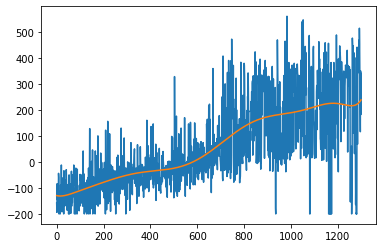

Episode : 1300/5000, Score : 394.0, Exploration : 27%
Episode : 1301/5000, Score : 352.0, Exploration : 27%
Episode : 1302/5000, Score : 393.0, Exploration : 27%
Episode : 1303/5000, Score : 258.0, Exploration : 27%
Episode : 1304/5000, Score : 216.0, Exploration : 27%
Episode : 1305/5000, Score : 176.0, Exploration : 27%
Episode : 1306/5000, Score : 264.0, Exploration : 27%
Episode : 1307/5000, Score : 286.0, Exploration : 27%
Episode : 1308/5000, Score : 184.0, Exploration : 27%
Episode : 1309/5000, Score : 242.0, Exploration : 27%
Episode : 1310/5000, Score : 84.0, Exploration : 27%
Episode : 1311/5000, Score : 264.0, Exploration : 27%
Episode : 1312/5000, Score : 278.0, Exploration : 27%
Episode : 1313/5000, Score : 320.0, Exploration : 27%
Episode : 1314/5000, Score : 380.0, Exploration : 27%
Episode : 1315/5000, Score : 136.0, Exploration : 27%
Episode : 1316/5000, Score : 60.0, Exploration : 27%
Episode : 1317/5000, Score : 224.0, Exploration : 27%
Episode : 1318/5000, Score : -

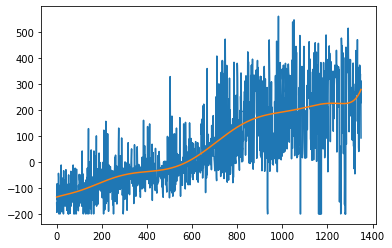

Episode : 1350/5000, Score : 76.0, Exploration : 26%
Episode : 1351/5000, Score : 64.0, Exploration : 26%
Episode : 1352/5000, Score : 182.0, Exploration : 26%
Episode : 1353/5000, Score : 358.0, Exploration : 26%
Episode : 1354/5000, Score : 388.0, Exploration : 26%
Episode : 1355/5000, Score : 60.0, Exploration : 26%
Episode : 1356/5000, Score : 56.0, Exploration : 26%
Episode : 1357/5000, Score : 18.0, Exploration : 26%
Episode : 1358/5000, Score : 80.0, Exploration : 26%
Episode : 1359/5000, Score : 66.0, Exploration : 26%
Episode : 1360/5000, Score : 90.0, Exploration : 26%
Episode : 1361/5000, Score : 180.0, Exploration : 26%
Episode : 1362/5000, Score : 216.0, Exploration : 26%
Episode : 1363/5000, Score : 312.0, Exploration : 26%
Episode : 1364/5000, Score : 268.0, Exploration : 26%
Episode : 1365/5000, Score : 134.0, Exploration : 26%
Episode : 1366/5000, Score : 272.0, Exploration : 25%
Episode : 1367/5000, Score : 138.0, Exploration : 25%
Episode : 1368/5000, Score : 248.0, 

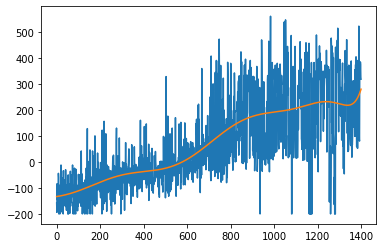

Episode : 1400/5000, Score : 66.0, Exploration : 25%
Episode : 1401/5000, Score : 373.0, Exploration : 25%
Episode : 1402/5000, Score : 182.0, Exploration : 25%
Episode : 1403/5000, Score : 378.0, Exploration : 25%
Episode : 1404/5000, Score : 490.0, Exploration : 25%
Episode : 1405/5000, Score : 514.0, Exploration : 25%
Episode : 1406/5000, Score : 437.0, Exploration : 24%
Episode : 1407/5000, Score : 319.0, Exploration : 24%
Episode : 1408/5000, Score : 321.0, Exploration : 24%
Episode : 1409/5000, Score : 352.0, Exploration : 24%
Episode : 1410/5000, Score : 448.0, Exploration : 24%
Episode : 1411/5000, Score : 436.0, Exploration : 24%
Episode : 1412/5000, Score : 68.0, Exploration : 24%
Episode : 1413/5000, Score : 26.0, Exploration : 24%
Episode : 1414/5000, Score : 340.0, Exploration : 24%
Episode : 1415/5000, Score : 311.0, Exploration : 24%
Episode : 1416/5000, Score : 352.0, Exploration : 24%
Episode : 1417/5000, Score : 386.0, Exploration : 24%
Episode : 1418/5000, Score : 33

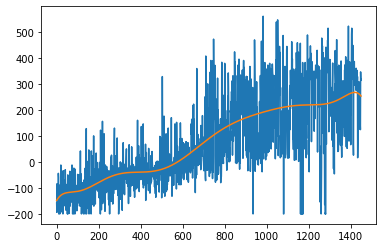

Episode : 1450/5000, Score : 352.0, Exploration : 23%
Episode : 1451/5000, Score : 302.0, Exploration : 23%
Episode : 1452/5000, Score : 310.0, Exploration : 23%
Episode : 1453/5000, Score : 382.0, Exploration : 23%
Episode : 1454/5000, Score : 108.0, Exploration : 23%
Episode : 1455/5000, Score : 230.0, Exploration : 23%
Episode : 1456/5000, Score : 78.0, Exploration : 23%
Episode : 1457/5000, Score : 50.0, Exploration : 23%
Episode : 1458/5000, Score : 314.0, Exploration : 23%
Episode : 1459/5000, Score : 408.0, Exploration : 23%
Episode : 1460/5000, Score : 430.0, Exploration : 23%
Episode : 1461/5000, Score : 432.0, Exploration : 23%
Episode : 1462/5000, Score : 374.0, Exploration : 23%
Episode : 1463/5000, Score : 366.0, Exploration : 23%
Episode : 1464/5000, Score : 412.0, Exploration : 23%
Episode : 1465/5000, Score : 236.0, Exploration : 23%
Episode : 1466/5000, Score : 318.0, Exploration : 23%
Episode : 1467/5000, Score : 132.0, Exploration : 23%
Episode : 1468/5000, Score : 3

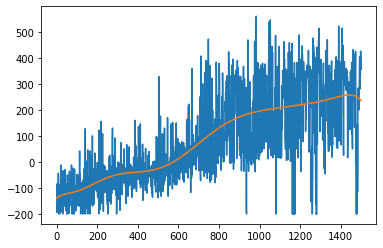

Episode : 1500/5000, Score : 28.0, Exploration : 22%
Episode : 1501/5000, Score : 492.0, Exploration : 22%
Episode : 1502/5000, Score : 336.0, Exploration : 22%
Episode : 1503/5000, Score : 350.0, Exploration : 22%
Episode : 1504/5000, Score : 305.0, Exploration : 22%
Episode : 1505/5000, Score : 264.0, Exploration : 22%
Episode : 1506/5000, Score : 160.0, Exploration : 22%
Episode : 1507/5000, Score : 311.0, Exploration : 22%
Episode : 1508/5000, Score : 349.0, Exploration : 22%
Episode : 1509/5000, Score : 303.0, Exploration : 22%
Episode : 1510/5000, Score : 319.0, Exploration : 22%
Episode : 1511/5000, Score : 336.0, Exploration : 22%
Episode : 1512/5000, Score : 323.0, Exploration : 22%
Episode : 1513/5000, Score : 298.0, Exploration : 22%
Episode : 1514/5000, Score : 307.0, Exploration : 22%
Episode : 1515/5000, Score : 301.0, Exploration : 22%
Episode : 1516/5000, Score : 406.0, Exploration : 22%
Episode : 1517/5000, Score : 374.0, Exploration : 22%
Episode : 1518/5000, Score : 

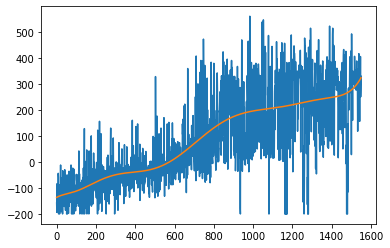

Episode : 1550/5000, Score : 284.0, Exploration : 21%
Episode : 1551/5000, Score : 76.0, Exploration : 21%
Episode : 1552/5000, Score : 274.0, Exploration : 21%
Episode : 1553/5000, Score : 324.0, Exploration : 21%
Episode : 1554/5000, Score : 336.0, Exploration : 21%
Episode : 1555/5000, Score : 319.0, Exploration : 21%
Episode : 1556/5000, Score : 325.0, Exploration : 21%
Episode : 1557/5000, Score : 349.0, Exploration : 21%
Episode : 1558/5000, Score : 312.0, Exploration : 21%
Episode : 1559/5000, Score : 284.0, Exploration : 21%
Episode : 1560/5000, Score : 490.0, Exploration : 21%
Episode : 1561/5000, Score : 307.0, Exploration : 21%
Episode : 1562/5000, Score : 300.0, Exploration : 21%
Episode : 1563/5000, Score : 112.0, Exploration : 21%
Episode : 1564/5000, Score : 329.0, Exploration : 21%
Episode : 1565/5000, Score : 269.0, Exploration : 21%
Episode : 1566/5000, Score : 371.0, Exploration : 21%
Episode : 1567/5000, Score : 100.0, Exploration : 21%
Episode : 1568/5000, Score : 

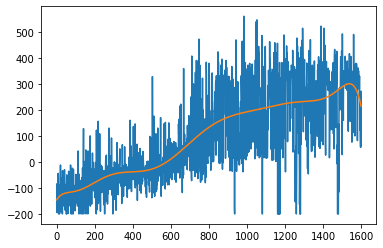

Episode : 1600/5000, Score : 80.0, Exploration : 20%
Episode : 1601/5000, Score : 46.0, Exploration : 20%
Episode : 1602/5000, Score : 68.0, Exploration : 20%
Episode : 1603/5000, Score : 74.0, Exploration : 20%
Episode : 1604/5000, Score : 82.0, Exploration : 20%
Episode : 1605/5000, Score : 354.0, Exploration : 20%
Episode : 1606/5000, Score : 222.0, Exploration : 20%
Episode : 1607/5000, Score : -22.0, Exploration : 20%
Episode : 1608/5000, Score : 232.0, Exploration : 20%
Episode : 1609/5000, Score : 287.0, Exploration : 20%
Episode : 1610/5000, Score : 242.0, Exploration : 20%
Episode : 1611/5000, Score : 361.0, Exploration : 20%
Episode : 1612/5000, Score : 265.0, Exploration : 20%
Episode : 1613/5000, Score : 334.0, Exploration : 20%
Episode : 1614/5000, Score : -2.0, Exploration : 20%
Episode : 1615/5000, Score : 96.0, Exploration : 20%
Episode : 1616/5000, Score : 4.0, Exploration : 20%
Episode : 1617/5000, Score : 10.0, Exploration : 20%
Episode : 1618/5000, Score : 80.0, Exp

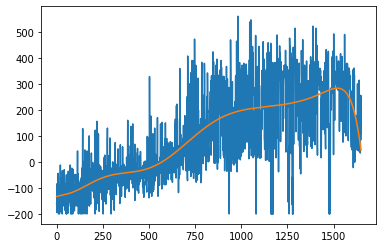

Episode : 1650/5000, Score : 92.0, Exploration : 19%
Episode : 1651/5000, Score : 58.0, Exploration : 19%
Episode : 1652/5000, Score : 106.0, Exploration : 19%
Episode : 1653/5000, Score : 120.0, Exploration : 19%
Episode : 1654/5000, Score : 176.0, Exploration : 19%
Episode : 1655/5000, Score : 268.0, Exploration : 19%
Episode : 1656/5000, Score : 64.0, Exploration : 19%
Episode : 1657/5000, Score : 310.0, Exploration : 19%
Episode : 1658/5000, Score : 162.0, Exploration : 19%
Episode : 1659/5000, Score : 354.0, Exploration : 19%
Episode : 1660/5000, Score : 364.0, Exploration : 19%
Episode : 1661/5000, Score : 256.0, Exploration : 19%
Episode : 1662/5000, Score : 350.0, Exploration : 19%
Episode : 1663/5000, Score : 88.0, Exploration : 19%
Episode : 1664/5000, Score : 198.0, Exploration : 19%
Episode : 1665/5000, Score : 344.0, Exploration : 19%
Episode : 1666/5000, Score : 74.0, Exploration : 19%
Episode : 1667/5000, Score : 374.0, Exploration : 19%
Episode : 1668/5000, Score : 348.

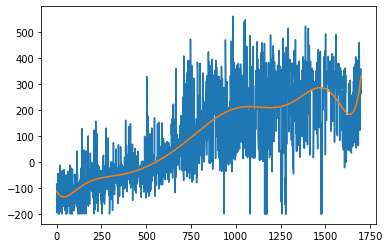

Episode : 1700/5000, Score : 94.0, Exploration : 18%
Episode : 1701/5000, Score : 289.0, Exploration : 18%
Episode : 1702/5000, Score : 333.0, Exploration : 18%
Episode : 1703/5000, Score : 163.0, Exploration : 18%
Episode : 1704/5000, Score : 152.0, Exploration : 18%
Episode : 1705/5000, Score : 191.0, Exploration : 18%
Episode : 1706/5000, Score : 278.0, Exploration : 18%
Episode : 1707/5000, Score : 354.0, Exploration : 18%
Episode : 1708/5000, Score : 102.0, Exploration : 18%
Episode : 1709/5000, Score : 92.0, Exploration : 18%
Episode : 1710/5000, Score : 403.0, Exploration : 18%
Episode : 1711/5000, Score : 94.0, Exploration : 18%
Episode : 1712/5000, Score : 376.0, Exploration : 18%
Episode : 1713/5000, Score : 416.0, Exploration : 18%
Episode : 1714/5000, Score : 354.0, Exploration : 18%
Episode : 1715/5000, Score : 558.0, Exploration : 18%
Episode : 1716/5000, Score : 399.0, Exploration : 18%
Episode : 1717/5000, Score : 443.0, Exploration : 18%
Episode : 1718/5000, Score : 36

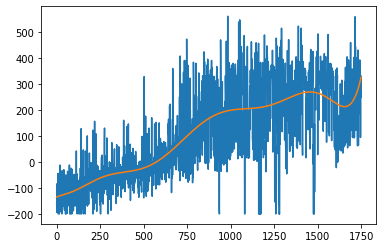

Episode : 1750/5000, Score : 348.0, Exploration : 17%
Episode : 1751/5000, Score : 308.0, Exploration : 17%
Episode : 1752/5000, Score : 467.0, Exploration : 17%
Episode : 1753/5000, Score : 168.0, Exploration : 17%
Episode : 1754/5000, Score : 478.0, Exploration : 17%
Episode : 1755/5000, Score : 52.0, Exploration : 17%
Episode : 1756/5000, Score : 450.0, Exploration : 17%
Episode : 1757/5000, Score : 391.0, Exploration : 17%
Episode : 1758/5000, Score : 349.0, Exploration : 17%
Episode : 1759/5000, Score : 464.0, Exploration : 17%
Episode : 1760/5000, Score : 96.0, Exploration : 17%
Episode : 1761/5000, Score : 432.0, Exploration : 17%
Episode : 1762/5000, Score : 242.0, Exploration : 17%
Episode : 1763/5000, Score : 90.0, Exploration : 17%
Episode : 1764/5000, Score : 309.0, Exploration : 17%
Episode : 1765/5000, Score : 441.0, Exploration : 17%
Episode : 1766/5000, Score : 348.0, Exploration : 17%
Episode : 1767/5000, Score : 382.0, Exploration : 17%
Episode : 1768/5000, Score : 11

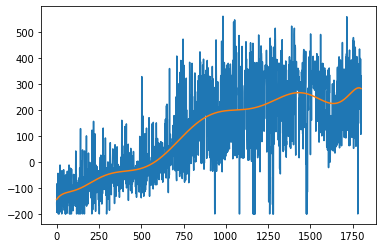

Episode : 1800/5000, Score : 338.0, Exploration : 17%
Episode : 1801/5000, Score : 254.0, Exploration : 16%
Episode : 1802/5000, Score : 281.0, Exploration : 16%
Episode : 1803/5000, Score : 371.0, Exploration : 16%
Episode : 1804/5000, Score : 374.0, Exploration : 16%
Episode : 1805/5000, Score : 319.0, Exploration : 16%
Episode : 1806/5000, Score : 338.0, Exploration : 16%
Episode : 1807/5000, Score : 340.0, Exploration : 16%
Episode : 1808/5000, Score : 277.0, Exploration : 16%
Episode : 1809/5000, Score : 196.0, Exploration : 16%
Episode : 1810/5000, Score : 314.0, Exploration : 16%
Episode : 1811/5000, Score : 335.0, Exploration : 16%
Episode : 1812/5000, Score : 287.0, Exploration : 16%
Episode : 1813/5000, Score : 192.0, Exploration : 16%
Episode : 1814/5000, Score : 124.0, Exploration : 16%
Episode : 1815/5000, Score : 374.0, Exploration : 16%
Episode : 1816/5000, Score : 400.0, Exploration : 16%
Episode : 1817/5000, Score : 140.0, Exploration : 16%
Episode : 1818/5000, Score :

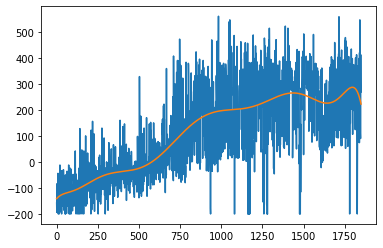

Episode : 1850/5000, Score : 526.0, Exploration : 16%
Episode : 1851/5000, Score : 480.0, Exploration : 16%
Episode : 1852/5000, Score : 357.0, Exploration : 16%
Episode : 1853/5000, Score : 351.0, Exploration : 16%
Episode : 1854/5000, Score : 302.0, Exploration : 16%
Episode : 1855/5000, Score : 386.0, Exploration : 16%
Episode : 1856/5000, Score : 334.0, Exploration : 16%
Episode : 1857/5000, Score : -200.0, Exploration : 16%
Episode : 1858/5000, Score : 258.0, Exploration : 16%
Episode : 1859/5000, Score : -200.0, Exploration : 16%
Episode : 1860/5000, Score : 112.0, Exploration : 16%
Episode : 1861/5000, Score : 300.0, Exploration : 16%
Episode : 1862/5000, Score : 352.0, Exploration : 16%
Episode : 1863/5000, Score : 246.0, Exploration : 16%
Episode : 1864/5000, Score : 338.0, Exploration : 15%
Episode : 1865/5000, Score : 418.0, Exploration : 15%
Episode : 1866/5000, Score : 402.0, Exploration : 15%
Episode : 1867/5000, Score : 390.0, Exploration : 15%
Episode : 1868/5000, Score

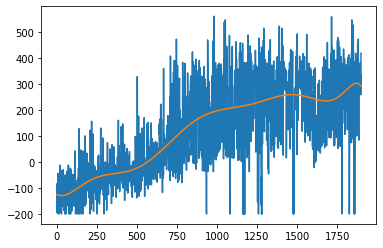

Episode : 1900/5000, Score : 508.0, Exploration : 15%
Episode : 1901/5000, Score : 398.0, Exploration : 15%
Episode : 1902/5000, Score : 434.0, Exploration : 15%
Episode : 1903/5000, Score : 452.0, Exploration : 15%
Episode : 1904/5000, Score : 405.0, Exploration : 15%
Episode : 1905/5000, Score : 388.0, Exploration : 15%
Episode : 1906/5000, Score : 248.0, Exploration : 15%
Episode : 1907/5000, Score : 266.0, Exploration : 15%
Episode : 1908/5000, Score : 220.0, Exploration : 15%
Episode : 1909/5000, Score : 196.0, Exploration : 15%
Episode : 1910/5000, Score : 218.0, Exploration : 15%
Episode : 1911/5000, Score : 208.0, Exploration : 15%
Episode : 1912/5000, Score : 406.0, Exploration : 15%
Episode : 1913/5000, Score : 304.0, Exploration : 15%
Episode : 1914/5000, Score : -12.0, Exploration : 15%
Episode : 1915/5000, Score : -200.0, Exploration : 15%
Episode : 1916/5000, Score : 138.0, Exploration : 15%
Episode : 1917/5000, Score : 170.0, Exploration : 15%
Episode : 1918/5000, Score 

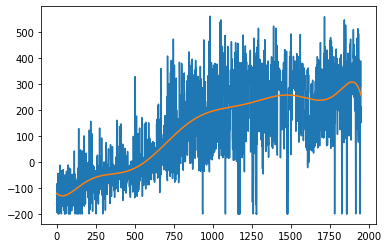

Episode : 1950/5000, Score : 212.0, Exploration : 14%
Episode : 1951/5000, Score : -26.0, Exploration : 14%
Episode : 1952/5000, Score : 307.0, Exploration : 14%
Episode : 1953/5000, Score : 406.0, Exploration : 14%
Episode : 1954/5000, Score : 358.0, Exploration : 14%
Episode : 1955/5000, Score : 66.0, Exploration : 14%
Episode : 1956/5000, Score : 327.0, Exploration : 14%
Episode : 1957/5000, Score : 322.0, Exploration : 14%
Episode : 1958/5000, Score : 288.0, Exploration : 14%
Episode : 1959/5000, Score : 206.0, Exploration : 14%
Episode : 1960/5000, Score : 118.0, Exploration : 14%
Episode : 1961/5000, Score : 68.0, Exploration : 14%
Episode : 1962/5000, Score : 164.0, Exploration : 14%
Episode : 1963/5000, Score : 194.0, Exploration : 14%
Episode : 1964/5000, Score : 332.0, Exploration : 14%
Episode : 1965/5000, Score : 224.0, Exploration : 14%
Episode : 1966/5000, Score : 266.0, Exploration : 14%
Episode : 1967/5000, Score : 285.0, Exploration : 14%
Episode : 1968/5000, Score : 2

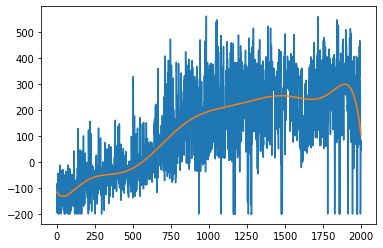

Episode : 2000/5000, Score : 78.0, Exploration : 14%
Episode : 2001/5000, Score : 56.0, Exploration : 14%
Episode : 2002/5000, Score : 82.0, Exploration : 13%
Episode : 2003/5000, Score : -2.0, Exploration : 13%
Episode : 2004/5000, Score : -200.0, Exploration : 13%
Episode : 2005/5000, Score : -200.0, Exploration : 13%
Episode : 2006/5000, Score : -170.0, Exploration : 13%
Episode : 2007/5000, Score : -200.0, Exploration : 13%
Episode : 2008/5000, Score : -200.0, Exploration : 13%
Episode : 2009/5000, Score : -142.0, Exploration : 13%
Episode : 2010/5000, Score : -200.0, Exploration : 13%
Episode : 2011/5000, Score : 148.0, Exploration : 13%
Episode : 2012/5000, Score : 84.0, Exploration : 13%
Episode : 2013/5000, Score : 64.0, Exploration : 13%
Episode : 2014/5000, Score : 70.0, Exploration : 13%
Episode : 2015/5000, Score : 84.0, Exploration : 13%
Episode : 2016/5000, Score : 140.0, Exploration : 13%
Episode : 2017/5000, Score : 110.0, Exploration : 13%
Episode : 2018/5000, Score : 

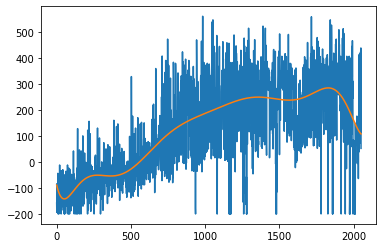

Episode : 2050/5000, Score : 68.0, Exploration : 13%
Episode : 2051/5000, Score : 390.0, Exploration : 13%
Episode : 2052/5000, Score : 88.0, Exploration : 13%
Episode : 2053/5000, Score : 140.0, Exploration : 13%
Episode : 2054/5000, Score : 80.0, Exploration : 13%
Episode : 2055/5000, Score : 142.0, Exploration : 13%
Episode : 2056/5000, Score : 90.0, Exploration : 13%
Episode : 2057/5000, Score : 430.0, Exploration : 13%
Episode : 2058/5000, Score : 156.0, Exploration : 13%
Episode : 2059/5000, Score : 148.0, Exploration : 13%
Episode : 2060/5000, Score : 126.0, Exploration : 13%
Episode : 2061/5000, Score : 84.0, Exploration : 13%
Episode : 2062/5000, Score : 94.0, Exploration : 13%
Episode : 2063/5000, Score : 326.0, Exploration : 13%
Episode : 2064/5000, Score : 58.0, Exploration : 13%
Episode : 2065/5000, Score : 60.0, Exploration : 13%
Episode : 2066/5000, Score : 64.0, Exploration : 13%
Episode : 2067/5000, Score : 120.0, Exploration : 13%
Episode : 2068/5000, Score : 62.0, Ex

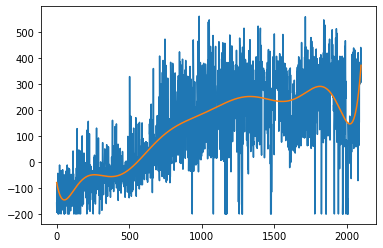

Episode : 2100/5000, Score : 430.0, Exploration : 12%
Episode : 2101/5000, Score : 322.0, Exploration : 12%
Episode : 2102/5000, Score : 299.0, Exploration : 12%
Episode : 2103/5000, Score : 164.0, Exploration : 12%
Episode : 2104/5000, Score : 324.0, Exploration : 12%
Episode : 2105/5000, Score : 312.0, Exploration : 12%
Episode : 2106/5000, Score : 86.0, Exploration : 12%
Episode : 2107/5000, Score : -66.0, Exploration : 12%
Episode : 2108/5000, Score : -10.0, Exploration : 12%
Episode : 2109/5000, Score : 148.0, Exploration : 12%
Episode : 2110/5000, Score : 180.0, Exploration : 12%
Episode : 2111/5000, Score : 118.0, Exploration : 12%
Episode : 2112/5000, Score : 142.0, Exploration : 12%
Episode : 2113/5000, Score : 40.0, Exploration : 12%
Episode : 2114/5000, Score : 94.0, Exploration : 12%
Episode : 2115/5000, Score : 60.0, Exploration : 12%
Episode : 2116/5000, Score : 68.0, Exploration : 12%
Episode : 2117/5000, Score : 114.0, Exploration : 12%
Episode : 2118/5000, Score : 178.

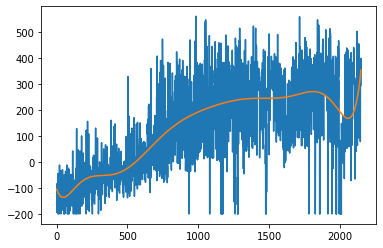

Episode : 2150/5000, Score : 130.0, Exploration : 12%
Episode : 2151/5000, Score : 391.0, Exploration : 12%
Episode : 2152/5000, Score : 486.0, Exploration : 12%
Episode : 2153/5000, Score : 182.0, Exploration : 12%
Episode : 2154/5000, Score : 442.0, Exploration : 12%
Episode : 2155/5000, Score : 454.0, Exploration : 12%
Episode : 2156/5000, Score : 440.0, Exploration : 12%
Episode : 2157/5000, Score : 384.0, Exploration : 12%
Episode : 2158/5000, Score : 371.0, Exploration : 12%
Episode : 2159/5000, Score : 305.0, Exploration : 12%
Episode : 2160/5000, Score : 338.0, Exploration : 12%
Episode : 2161/5000, Score : 250.0, Exploration : 12%
Episode : 2162/5000, Score : 330.0, Exploration : 11%
Episode : 2163/5000, Score : 396.0, Exploration : 11%
Episode : 2164/5000, Score : 470.0, Exploration : 11%
Episode : 2165/5000, Score : 383.0, Exploration : 11%
Episode : 2166/5000, Score : 378.0, Exploration : 11%
Episode : 2167/5000, Score : 412.0, Exploration : 11%
Episode : 2168/5000, Score :

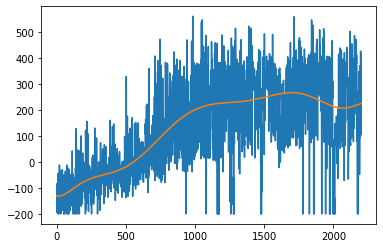

Episode : 2200/5000, Score : 372.0, Exploration : 11%
Episode : 2201/5000, Score : 372.0, Exploration : 11%
Episode : 2202/5000, Score : 80.0, Exploration : 11%
Episode : 2203/5000, Score : 289.0, Exploration : 11%
Episode : 2204/5000, Score : 308.0, Exploration : 11%
Episode : 2205/5000, Score : 106.0, Exploration : 11%
Episode : 2206/5000, Score : 114.0, Exploration : 11%
Episode : 2207/5000, Score : 82.0, Exploration : 11%
Episode : 2208/5000, Score : 84.0, Exploration : 11%
Episode : 2209/5000, Score : 238.0, Exploration : 11%
Episode : 2210/5000, Score : 106.0, Exploration : 11%
Episode : 2211/5000, Score : 403.0, Exploration : 11%
Episode : 2212/5000, Score : 408.0, Exploration : 11%
Episode : 2213/5000, Score : 360.0, Exploration : 11%
Episode : 2214/5000, Score : 90.0, Exploration : 11%
Episode : 2215/5000, Score : 128.0, Exploration : 11%
Episode : 2216/5000, Score : 324.0, Exploration : 11%
Episode : 2217/5000, Score : 296.0, Exploration : 11%
Episode : 2218/5000, Score : 272

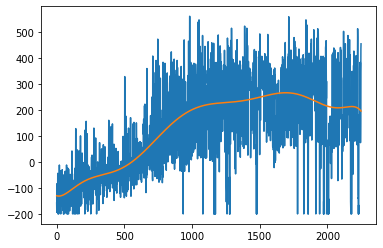

Episode : 2250/5000, Score : 360.0, Exploration : 11%
Episode : 2251/5000, Score : 390.0, Exploration : 11%
Episode : 2252/5000, Score : 209.0, Exploration : 11%
Episode : 2253/5000, Score : -96.0, Exploration : 10%
Episode : 2254/5000, Score : 309.0, Exploration : 10%
Episode : 2255/5000, Score : 108.0, Exploration : 10%
Episode : 2256/5000, Score : 430.0, Exploration : 10%
Episode : 2257/5000, Score : 90.0, Exploration : 10%
Episode : 2258/5000, Score : 410.0, Exploration : 10%
Episode : 2259/5000, Score : 132.0, Exploration : 10%
Episode : 2260/5000, Score : 70.0, Exploration : 10%
Episode : 2261/5000, Score : 54.0, Exploration : 10%
Episode : 2262/5000, Score : 56.0, Exploration : 10%
Episode : 2263/5000, Score : -200.0, Exploration : 10%
Episode : 2264/5000, Score : 314.0, Exploration : 10%
Episode : 2265/5000, Score : 250.0, Exploration : 10%
Episode : 2266/5000, Score : 244.0, Exploration : 10%
Episode : 2267/5000, Score : 414.0, Exploration : 10%
Episode : 2268/5000, Score : 10

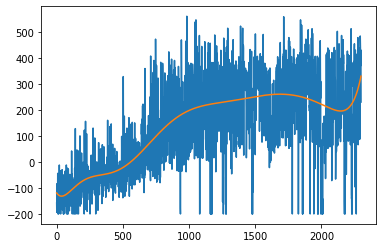

Episode : 2300/5000, Score : 408.0, Exploration : 10%
Episode : 2301/5000, Score : 368.0, Exploration : 10%
Episode : 2302/5000, Score : 82.0, Exploration : 10%
Episode : 2303/5000, Score : 396.0, Exploration : 10%
Episode : 2304/5000, Score : 334.0, Exploration : 10%
Episode : 2305/5000, Score : 422.0, Exploration : 10%
Episode : 2306/5000, Score : 372.0, Exploration : 10%
Episode : 2307/5000, Score : -200.0, Exploration : 10%
Episode : 2308/5000, Score : 446.0, Exploration : 10%
Episode : 2309/5000, Score : 378.0, Exploration : 10%
Episode : 2310/5000, Score : 398.0, Exploration : 10%
Episode : 2311/5000, Score : 228.0, Exploration : 10%
Episode : 2312/5000, Score : -184.0, Exploration : 10%
Episode : 2313/5000, Score : -200.0, Exploration : 10%
Episode : 2314/5000, Score : 284.0, Exploration : 10%
Episode : 2315/5000, Score : -200.0, Exploration : 10%
Episode : 2316/5000, Score : -200.0, Exploration : 10%
Episode : 2317/5000, Score : 221.0, Exploration : 10%
Episode : 2318/5000, Sco

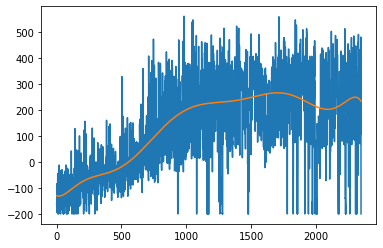

Episode : 2350/5000, Score : 486.0, Exploration : 10%
Episode : 2351/5000, Score : 294.0, Exploration : 10%
Episode : 2352/5000, Score : 70.0, Exploration : 10%
Episode : 2353/5000, Score : 407.0, Exploration : 9%
Episode : 2354/5000, Score : 412.0, Exploration : 9%
Episode : 2355/5000, Score : 334.0, Exploration : 9%
Episode : 2356/5000, Score : 244.0, Exploration : 9%
Episode : 2357/5000, Score : 299.0, Exploration : 9%
Episode : 2358/5000, Score : 291.0, Exploration : 9%
Episode : 2359/5000, Score : 408.0, Exploration : 9%
Episode : 2360/5000, Score : 378.0, Exploration : 9%
Episode : 2361/5000, Score : 405.0, Exploration : 9%
Episode : 2362/5000, Score : 309.0, Exploration : 9%
Episode : 2363/5000, Score : 331.0, Exploration : 9%
Episode : 2364/5000, Score : 402.0, Exploration : 9%
Episode : 2365/5000, Score : 126.0, Exploration : 9%
Episode : 2366/5000, Score : 297.0, Exploration : 9%
Episode : 2367/5000, Score : 379.0, Exploration : 9%
Episode : 2368/5000, Score : 366.0, Explorat

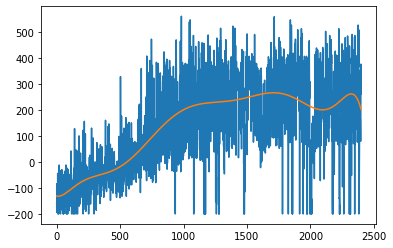

Episode : 2400/5000, Score : 102.0, Exploration : 9%
Episode : 2401/5000, Score : 208.0, Exploration : 9%
Episode : 2402/5000, Score : 162.0, Exploration : 9%
Episode : 2403/5000, Score : 360.0, Exploration : 9%
Episode : 2404/5000, Score : 224.0, Exploration : 9%
Episode : 2405/5000, Score : 70.0, Exploration : 9%
Episode : 2406/5000, Score : 112.0, Exploration : 9%
Episode : 2407/5000, Score : 134.0, Exploration : 9%
Episode : 2408/5000, Score : 372.0, Exploration : 9%
Episode : 2409/5000, Score : 374.0, Exploration : 9%
Episode : 2410/5000, Score : 428.0, Exploration : 9%
Episode : 2411/5000, Score : 230.0, Exploration : 9%
Episode : 2412/5000, Score : 336.0, Exploration : 9%
Episode : 2413/5000, Score : 382.0, Exploration : 9%
Episode : 2414/5000, Score : 441.0, Exploration : 9%
Episode : 2415/5000, Score : 476.0, Exploration : 9%
Episode : 2416/5000, Score : 464.0, Exploration : 9%
Episode : 2417/5000, Score : 399.0, Exploration : 9%
Episode : 2418/5000, Score : 430.0, Exploration

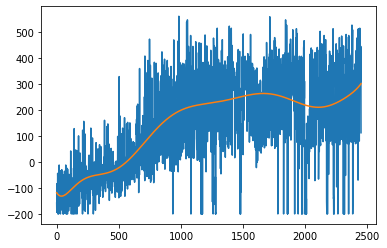

Episode : 2450/5000, Score : 102.0, Exploration : 9%
Episode : 2451/5000, Score : 388.0, Exploration : 9%
Episode : 2452/5000, Score : 374.0, Exploration : 9%
Episode : 2453/5000, Score : -200.0, Exploration : 9%
Episode : 2454/5000, Score : 8.0, Exploration : 9%
Episode : 2455/5000, Score : -188.0, Exploration : 9%
Episode : 2456/5000, Score : -200.0, Exploration : 9%
Episode : 2457/5000, Score : 248.0, Exploration : 9%
Episode : 2458/5000, Score : -90.0, Exploration : 9%
Episode : 2459/5000, Score : 394.0, Exploration : 9%
Episode : 2460/5000, Score : 130.0, Exploration : 9%
Episode : 2461/5000, Score : 96.0, Exploration : 9%
Episode : 2462/5000, Score : 420.0, Exploration : 9%
Episode : 2463/5000, Score : 378.0, Exploration : 9%
Episode : 2464/5000, Score : 156.0, Exploration : 8%
Episode : 2465/5000, Score : 74.0, Exploration : 8%
Episode : 2466/5000, Score : 82.0, Exploration : 8%
Episode : 2467/5000, Score : 412.0, Exploration : 8%
Episode : 2468/5000, Score : 92.0, Exploration :

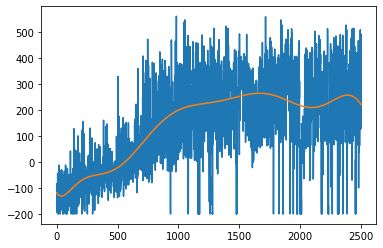

Episode : 2500/5000, Score : 248.0, Exploration : 8%
Episode : 2501/5000, Score : -200.0, Exploration : 8%
Episode : 2502/5000, Score : 52.0, Exploration : 8%
Episode : 2503/5000, Score : 110.0, Exploration : 8%
Episode : 2504/5000, Score : 72.0, Exploration : 8%
Episode : 2505/5000, Score : 212.0, Exploration : 8%
Episode : 2506/5000, Score : 176.0, Exploration : 8%
Episode : 2507/5000, Score : 252.0, Exploration : 8%
Episode : 2508/5000, Score : 282.0, Exploration : 8%
Episode : 2509/5000, Score : -14.0, Exploration : 8%
Episode : 2510/5000, Score : -138.0, Exploration : 8%
Episode : 2511/5000, Score : -200.0, Exploration : 8%
Episode : 2512/5000, Score : -200.0, Exploration : 8%
Episode : 2513/5000, Score : 246.0, Exploration : 8%
Episode : 2514/5000, Score : 18.0, Exploration : 8%
Episode : 2515/5000, Score : -62.0, Exploration : 8%
Episode : 2516/5000, Score : 174.0, Exploration : 8%
Episode : 2517/5000, Score : -148.0, Exploration : 8%
Episode : 2518/5000, Score : 172.0, Explorat

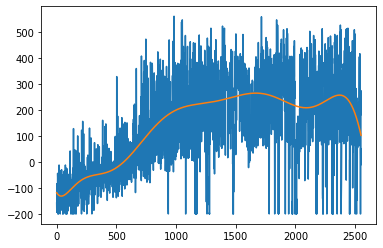

Episode : 2550/5000, Score : 86.0, Exploration : 8%
Episode : 2551/5000, Score : 254.0, Exploration : 8%
Episode : 2552/5000, Score : 420.0, Exploration : 8%
Episode : 2553/5000, Score : 443.0, Exploration : 8%
Episode : 2554/5000, Score : 226.0, Exploration : 8%
Episode : 2555/5000, Score : 388.0, Exploration : 8%
Episode : 2556/5000, Score : 62.0, Exploration : 8%
Episode : 2557/5000, Score : 168.0, Exploration : 8%
Episode : 2558/5000, Score : 284.0, Exploration : 8%
Episode : 2559/5000, Score : 394.0, Exploration : 8%
Episode : 2560/5000, Score : 420.0, Exploration : 8%
Episode : 2561/5000, Score : 372.0, Exploration : 8%
Episode : 2562/5000, Score : 392.0, Exploration : 8%
Episode : 2563/5000, Score : 464.0, Exploration : 8%
Episode : 2564/5000, Score : -200.0, Exploration : 8%
Episode : 2565/5000, Score : 340.0, Exploration : 8%
Episode : 2566/5000, Score : 312.0, Exploration : 8%
Episode : 2567/5000, Score : 441.0, Exploration : 8%
Episode : 2568/5000, Score : 447.0, Exploration

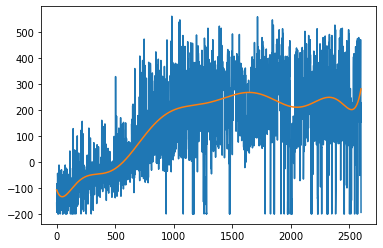

Episode : 2600/5000, Score : 282.0, Exploration : 7%
Episode : 2601/5000, Score : 108.0, Exploration : 7%
Episode : 2602/5000, Score : 323.0, Exploration : 7%
Episode : 2603/5000, Score : 356.0, Exploration : 7%
Episode : 2604/5000, Score : 369.0, Exploration : 7%
Episode : 2605/5000, Score : 464.0, Exploration : 7%
Episode : 2606/5000, Score : 321.0, Exploration : 7%
Episode : 2607/5000, Score : 152.0, Exploration : 7%
Episode : 2608/5000, Score : 220.0, Exploration : 7%
Episode : 2609/5000, Score : 344.0, Exploration : 7%
Episode : 2610/5000, Score : 287.0, Exploration : 7%
Episode : 2611/5000, Score : 294.0, Exploration : 7%
Episode : 2612/5000, Score : 522.0, Exploration : 7%
Episode : 2613/5000, Score : 341.0, Exploration : 7%
Episode : 2614/5000, Score : 481.0, Exploration : 7%
Episode : 2615/5000, Score : 401.0, Exploration : 7%
Episode : 2616/5000, Score : 290.0, Exploration : 7%
Episode : 2617/5000, Score : 394.0, Exploration : 7%
Episode : 2618/5000, Score : 345.0, Exploratio

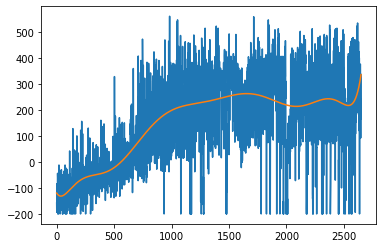

Episode : 2650/5000, Score : 450.0, Exploration : 7%
Episode : 2651/5000, Score : 437.0, Exploration : 7%
Episode : 2652/5000, Score : 334.0, Exploration : 7%
Episode : 2653/5000, Score : 432.0, Exploration : 7%
Episode : 2654/5000, Score : 415.0, Exploration : 7%
Episode : 2655/5000, Score : 338.0, Exploration : 7%
Episode : 2656/5000, Score : 326.0, Exploration : 7%
Episode : 2657/5000, Score : 257.0, Exploration : 7%
Episode : 2658/5000, Score : 240.0, Exploration : 7%
Episode : 2659/5000, Score : 180.0, Exploration : 7%
Episode : 2660/5000, Score : 358.0, Exploration : 7%
Episode : 2661/5000, Score : 376.0, Exploration : 7%
Episode : 2662/5000, Score : 489.0, Exploration : 7%
Episode : 2663/5000, Score : 428.0, Exploration : 7%
Episode : 2664/5000, Score : 330.0, Exploration : 7%
Episode : 2665/5000, Score : 352.0, Exploration : 7%
Episode : 2666/5000, Score : 285.0, Exploration : 7%
Episode : 2667/5000, Score : 274.0, Exploration : 7%
Episode : 2668/5000, Score : 596.0, Exploratio

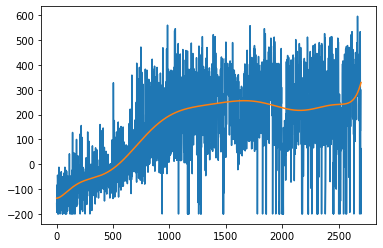

Episode : 2700/5000, Score : 222.0, Exploration : 7%
Episode : 2701/5000, Score : 338.0, Exploration : 7%
Episode : 2702/5000, Score : 273.0, Exploration : 7%
Episode : 2703/5000, Score : 66.0, Exploration : 7%
Episode : 2704/5000, Score : 164.0, Exploration : 7%
Episode : 2705/5000, Score : 338.0, Exploration : 7%
Episode : 2706/5000, Score : 312.0, Exploration : 7%
Episode : 2707/5000, Score : 268.0, Exploration : 7%
Episode : 2708/5000, Score : 240.0, Exploration : 7%
Episode : 2709/5000, Score : 403.0, Exploration : 7%
Episode : 2710/5000, Score : 305.0, Exploration : 7%
Episode : 2711/5000, Score : 170.0, Exploration : 7%
Episode : 2712/5000, Score : 378.0, Exploration : 7%
Episode : 2713/5000, Score : 379.0, Exploration : 7%
Episode : 2714/5000, Score : 341.0, Exploration : 7%
Episode : 2715/5000, Score : 316.0, Exploration : 7%
Episode : 2716/5000, Score : 430.0, Exploration : 7%
Episode : 2717/5000, Score : 430.0, Exploration : 7%
Episode : 2718/5000, Score : 412.0, Exploration

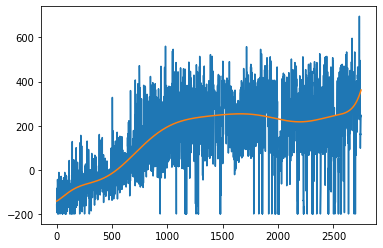

Episode : 2750/5000, Score : 292.0, Exploration : 6%
Episode : 2751/5000, Score : 140.0, Exploration : 6%
Episode : 2752/5000, Score : 276.0, Exploration : 6%
Episode : 2753/5000, Score : 314.0, Exploration : 6%
Episode : 2754/5000, Score : 84.0, Exploration : 6%
Episode : 2755/5000, Score : 414.0, Exploration : 6%
Episode : 2756/5000, Score : 449.0, Exploration : 6%
Episode : 2757/5000, Score : 412.0, Exploration : 6%
Episode : 2758/5000, Score : 455.0, Exploration : 6%
Episode : 2759/5000, Score : 408.0, Exploration : 6%
Episode : 2760/5000, Score : 406.0, Exploration : 6%
Episode : 2761/5000, Score : 435.0, Exploration : 6%
Episode : 2762/5000, Score : 512.0, Exploration : 6%
Episode : 2763/5000, Score : 410.0, Exploration : 6%
Episode : 2764/5000, Score : 448.0, Exploration : 6%
Episode : 2765/5000, Score : 472.0, Exploration : 6%
Episode : 2766/5000, Score : 346.0, Exploration : 6%
Episode : 2767/5000, Score : 66.0, Exploration : 6%
Episode : 2768/5000, Score : 84.0, Exploration :

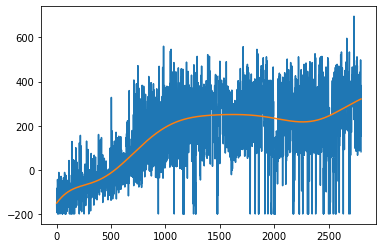

Episode : 2800/5000, Score : 348.0, Exploration : 6%
Episode : 2801/5000, Score : 484.0, Exploration : 6%
Episode : 2802/5000, Score : 377.0, Exploration : 6%
Episode : 2803/5000, Score : 378.0, Exploration : 6%
Episode : 2804/5000, Score : 335.0, Exploration : 6%
Episode : 2805/5000, Score : 399.0, Exploration : 6%
Episode : 2806/5000, Score : 396.0, Exploration : 6%
Episode : 2807/5000, Score : 476.0, Exploration : 6%
Episode : 2808/5000, Score : 361.0, Exploration : 6%
Episode : 2809/5000, Score : 427.0, Exploration : 6%
Episode : 2810/5000, Score : 496.0, Exploration : 6%
Episode : 2811/5000, Score : 397.0, Exploration : 6%
Episode : 2812/5000, Score : 351.0, Exploration : 6%
Episode : 2813/5000, Score : 286.0, Exploration : 6%
Episode : 2814/5000, Score : 460.0, Exploration : 6%
Episode : 2815/5000, Score : 396.0, Exploration : 6%
Episode : 2816/5000, Score : 373.0, Exploration : 6%
Episode : 2817/5000, Score : 427.0, Exploration : 6%
Episode : 2818/5000, Score : 349.0, Exploratio

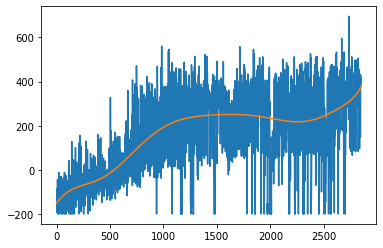

Episode : 2850/5000, Score : 249.0, Exploration : 6%
Episode : 2851/5000, Score : 419.0, Exploration : 6%
Episode : 2852/5000, Score : 350.0, Exploration : 6%
Episode : 2853/5000, Score : 380.0, Exploration : 6%
Episode : 2854/5000, Score : 82.0, Exploration : 6%
Episode : 2855/5000, Score : 74.0, Exploration : 6%
Episode : 2856/5000, Score : 488.0, Exploration : 6%
Episode : 2857/5000, Score : 100.0, Exploration : 6%
Episode : 2858/5000, Score : 340.0, Exploration : 6%
Episode : 2859/5000, Score : -200.0, Exploration : 6%
Episode : 2860/5000, Score : -200.0, Exploration : 6%
Episode : 2861/5000, Score : -70.0, Exploration : 6%
Episode : 2862/5000, Score : -164.0, Exploration : 6%
Episode : 2863/5000, Score : 326.0, Exploration : 6%
Episode : 2864/5000, Score : 211.0, Exploration : 6%
Episode : 2865/5000, Score : 122.0, Exploration : 6%
Episode : 2866/5000, Score : -200.0, Exploration : 6%
Episode : 2867/5000, Score : -200.0, Exploration : 6%
Episode : 2868/5000, Score : 100.0, Explora

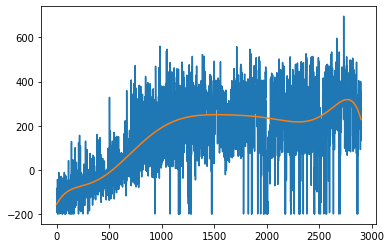

Episode : 2900/5000, Score : 82.0, Exploration : 5%
Episode : 2901/5000, Score : 352.0, Exploration : 5%
Episode : 2902/5000, Score : 374.0, Exploration : 5%
Episode : 2903/5000, Score : 348.0, Exploration : 5%
Episode : 2904/5000, Score : 202.0, Exploration : 5%
Episode : 2905/5000, Score : 242.0, Exploration : 5%
Episode : 2906/5000, Score : 266.0, Exploration : 5%
Episode : 2907/5000, Score : 268.0, Exploration : 5%
Episode : 2908/5000, Score : 324.0, Exploration : 5%
Episode : 2909/5000, Score : 310.0, Exploration : 5%
Episode : 2910/5000, Score : 318.0, Exploration : 5%
Episode : 2911/5000, Score : 154.0, Exploration : 5%
Episode : 2912/5000, Score : 94.0, Exploration : 5%
Episode : 2913/5000, Score : 408.0, Exploration : 5%
Episode : 2914/5000, Score : 386.0, Exploration : 5%
Episode : 2915/5000, Score : 380.0, Exploration : 5%
Episode : 2916/5000, Score : 192.0, Exploration : 5%
Episode : 2917/5000, Score : 92.0, Exploration : 5%
Episode : 2918/5000, Score : 409.0, Exploration :

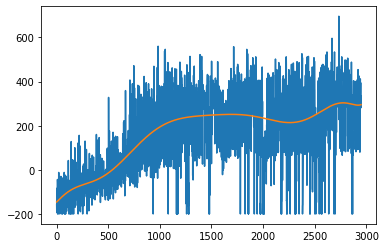

Episode : 2950/5000, Score : 334.0, Exploration : 5%
Episode : 2951/5000, Score : -200.0, Exploration : 5%
Episode : 2952/5000, Score : 40.0, Exploration : 5%
Episode : 2953/5000, Score : 320.0, Exploration : 5%
Episode : 2954/5000, Score : 144.0, Exploration : 5%
Episode : 2955/5000, Score : 186.0, Exploration : 5%
Episode : 2956/5000, Score : 304.0, Exploration : 5%
Episode : 2957/5000, Score : 404.0, Exploration : 5%
Episode : 2958/5000, Score : 362.0, Exploration : 5%
Episode : 2959/5000, Score : 180.0, Exploration : 5%
Episode : 2960/5000, Score : 176.0, Exploration : 5%
Episode : 2961/5000, Score : 416.0, Exploration : 5%
Episode : 2962/5000, Score : 390.0, Exploration : 5%
Episode : 2963/5000, Score : 338.0, Exploration : 5%
Episode : 2964/5000, Score : 324.0, Exploration : 5%
Episode : 2965/5000, Score : 276.0, Exploration : 5%
Episode : 2966/5000, Score : 360.0, Exploration : 5%
Episode : 2967/5000, Score : 322.0, Exploration : 5%
Episode : 2968/5000, Score : 404.0, Exploratio

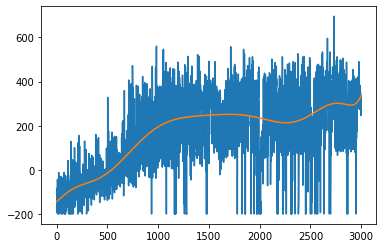

Episode : 3000/5000, Score : 285.0, Exploration : 5%
Episode : 3001/5000, Score : 428.0, Exploration : 5%
Episode : 3002/5000, Score : 190.0, Exploration : 5%
Episode : 3003/5000, Score : 406.0, Exploration : 5%
Episode : 3004/5000, Score : 366.0, Exploration : 5%
Episode : 3005/5000, Score : 356.0, Exploration : 5%
Episode : 3006/5000, Score : 337.0, Exploration : 5%
Episode : 3007/5000, Score : -200.0, Exploration : 5%
Episode : 3008/5000, Score : -200.0, Exploration : 5%
Episode : 3009/5000, Score : -120.0, Exploration : 5%
Episode : 3010/5000, Score : -200.0, Exploration : 5%
Episode : 3011/5000, Score : 56.0, Exploration : 5%
Episode : 3012/5000, Score : 96.0, Exploration : 5%
Episode : 3013/5000, Score : 226.0, Exploration : 5%
Episode : 3014/5000, Score : 178.0, Exploration : 5%
Episode : 3015/5000, Score : 206.0, Exploration : 5%
Episode : 3016/5000, Score : 320.0, Exploration : 5%
Episode : 3017/5000, Score : 426.0, Exploration : 5%
Episode : 3018/5000, Score : 274.0, Explorat

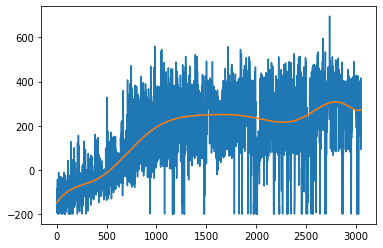

Episode : 3050/5000, Score : 308.0, Exploration : 5%
Episode : 3051/5000, Score : 314.0, Exploration : 5%
Episode : 3052/5000, Score : -68.0, Exploration : 5%
Episode : 3053/5000, Score : -94.0, Exploration : 5%
Episode : 3054/5000, Score : -200.0, Exploration : 5%
Episode : 3055/5000, Score : -200.0, Exploration : 5%
Episode : 3056/5000, Score : 388.0, Exploration : 5%
Episode : 3057/5000, Score : 352.0, Exploration : 5%
Episode : 3058/5000, Score : 254.0, Exploration : 5%
Episode : 3059/5000, Score : 52.0, Exploration : 5%
Episode : 3060/5000, Score : 426.0, Exploration : 5%
Episode : 3061/5000, Score : 146.0, Exploration : 5%
Episode : 3062/5000, Score : 428.0, Exploration : 5%
Episode : 3063/5000, Score : 378.0, Exploration : 5%
Episode : 3064/5000, Score : 382.0, Exploration : 5%
Episode : 3065/5000, Score : 308.0, Exploration : 5%
Episode : 3066/5000, Score : 366.0, Exploration : 5%
Episode : 3067/5000, Score : 288.0, Exploration : 5%
Episode : 3068/5000, Score : 398.0, Explorati

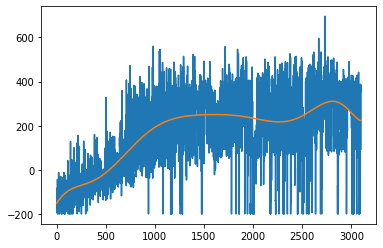

Episode : 3100/5000, Score : 384.0, Exploration : 4%
Episode : 3101/5000, Score : 252.0, Exploration : 4%
Episode : 3102/5000, Score : 347.0, Exploration : 4%
Episode : 3103/5000, Score : 404.0, Exploration : 4%
Episode : 3104/5000, Score : 259.0, Exploration : 4%
Episode : 3105/5000, Score : 580.0, Exploration : 4%
Episode : 3106/5000, Score : 421.0, Exploration : 4%
Episode : 3107/5000, Score : -200.0, Exploration : 4%
Episode : 3108/5000, Score : -200.0, Exploration : 4%
Episode : 3109/5000, Score : -200.0, Exploration : 4%
Episode : 3110/5000, Score : 265.0, Exploration : 4%
Episode : 3111/5000, Score : -200.0, Exploration : 4%
Episode : 3112/5000, Score : -200.0, Exploration : 4%
Episode : 3113/5000, Score : -200.0, Exploration : 4%
Episode : 3114/5000, Score : -200.0, Exploration : 4%
Episode : 3115/5000, Score : -200.0, Exploration : 4%
Episode : 3116/5000, Score : 92.0, Exploration : 4%
Episode : 3117/5000, Score : 92.0, Exploration : 4%
Episode : 3118/5000, Score : 180.0, Expl

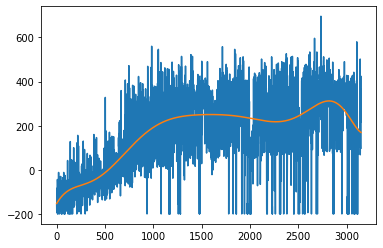

Episode : 3150/5000, Score : 426.0, Exploration : 4%
Episode : 3151/5000, Score : 435.0, Exploration : 4%
Episode : 3152/5000, Score : 132.0, Exploration : 4%
Episode : 3153/5000, Score : 341.0, Exploration : 4%
Episode : 3154/5000, Score : 415.0, Exploration : 4%
Episode : 3155/5000, Score : 434.0, Exploration : 4%
Episode : 3156/5000, Score : 225.0, Exploration : 4%
Episode : 3157/5000, Score : 104.0, Exploration : 4%
Episode : 3158/5000, Score : 388.0, Exploration : 4%
Episode : 3159/5000, Score : 342.0, Exploration : 4%
Episode : 3160/5000, Score : 443.0, Exploration : 4%
Episode : 3161/5000, Score : 299.0, Exploration : 4%
Episode : 3162/5000, Score : 321.0, Exploration : 4%
Episode : 3163/5000, Score : 498.0, Exploration : 4%
Episode : 3164/5000, Score : 152.0, Exploration : 4%
Episode : 3165/5000, Score : 374.0, Exploration : 4%
Episode : 3166/5000, Score : 92.0, Exploration : 4%
Episode : 3167/5000, Score : 416.0, Exploration : 4%
Episode : 3168/5000, Score : 382.0, Exploration

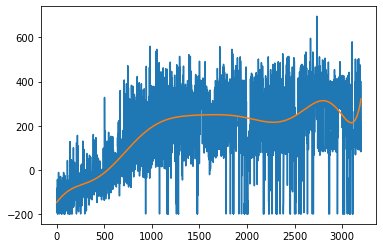

Episode : 3200/5000, Score : 378.0, Exploration : 4%
Episode : 3201/5000, Score : 100.0, Exploration : 4%
Episode : 3202/5000, Score : 386.0, Exploration : 4%
Episode : 3203/5000, Score : 72.0, Exploration : 4%
Episode : 3204/5000, Score : 460.0, Exploration : 4%
Episode : 3205/5000, Score : 382.0, Exploration : 4%
Episode : 3206/5000, Score : 442.0, Exploration : 4%
Episode : 3207/5000, Score : 428.0, Exploration : 4%
Episode : 3208/5000, Score : 339.0, Exploration : 4%
Episode : 3209/5000, Score : 406.0, Exploration : 4%
Episode : 3210/5000, Score : 114.0, Exploration : 4%
Episode : 3211/5000, Score : 352.0, Exploration : 4%
Episode : 3212/5000, Score : 118.0, Exploration : 4%
Episode : 3213/5000, Score : 68.0, Exploration : 4%
Episode : 3214/5000, Score : 124.0, Exploration : 4%
Episode : 3215/5000, Score : 92.0, Exploration : 4%
Episode : 3216/5000, Score : 400.0, Exploration : 4%
Episode : 3217/5000, Score : 428.0, Exploration : 4%
Episode : 3218/5000, Score : 196.0, Exploration :

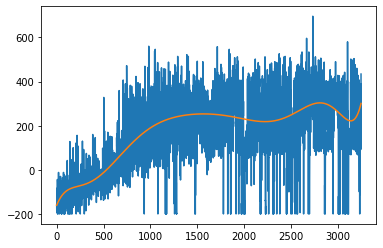

Episode : 3250/5000, Score : 88.0, Exploration : 4%
Episode : 3251/5000, Score : 120.0, Exploration : 4%
Episode : 3252/5000, Score : 418.0, Exploration : 4%
Episode : 3253/5000, Score : 226.0, Exploration : 4%
Episode : 3254/5000, Score : 288.0, Exploration : 4%
Episode : 3255/5000, Score : 349.0, Exploration : 4%
Episode : 3256/5000, Score : 403.0, Exploration : 4%
Episode : 3257/5000, Score : 290.0, Exploration : 4%
Episode : 3258/5000, Score : 90.0, Exploration : 4%
Episode : 3259/5000, Score : 370.0, Exploration : 4%
Episode : 3260/5000, Score : 372.0, Exploration : 4%
Episode : 3261/5000, Score : 180.0, Exploration : 4%
Episode : 3262/5000, Score : 192.0, Exploration : 4%
Episode : 3263/5000, Score : 332.0, Exploration : 4%
Episode : 3264/5000, Score : 315.0, Exploration : 4%
Episode : 3265/5000, Score : 326.0, Exploration : 4%
Episode : 3266/5000, Score : 134.0, Exploration : 4%
Episode : 3267/5000, Score : 92.0, Exploration : 4%
Episode : 3268/5000, Score : 96.0, Exploration : 

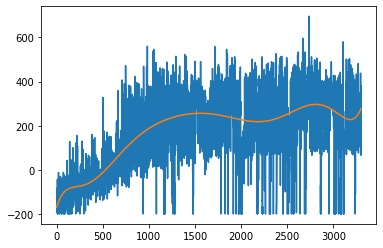

Episode : 3300/5000, Score : 390.0, Exploration : 4%
Episode : 3301/5000, Score : 383.0, Exploration : 4%
Episode : 3302/5000, Score : 362.0, Exploration : 4%
Episode : 3303/5000, Score : 401.0, Exploration : 4%
Episode : 3304/5000, Score : 315.0, Exploration : 4%
Episode : 3305/5000, Score : 392.0, Exploration : 4%
Episode : 3306/5000, Score : 414.0, Exploration : 4%
Episode : 3307/5000, Score : 182.0, Exploration : 4%
Episode : 3308/5000, Score : 386.0, Exploration : 4%
Episode : 3309/5000, Score : 338.0, Exploration : 4%
Episode : 3310/5000, Score : 378.0, Exploration : 4%
Episode : 3311/5000, Score : 395.0, Exploration : 4%
Episode : 3312/5000, Score : 445.0, Exploration : 4%
Episode : 3313/5000, Score : 316.0, Exploration : 4%
Episode : 3314/5000, Score : 252.0, Exploration : 4%
Episode : 3315/5000, Score : 398.0, Exploration : 4%
Episode : 3316/5000, Score : 423.0, Exploration : 4%
Episode : 3317/5000, Score : 148.0, Exploration : 4%
Episode : 3318/5000, Score : 368.0, Exploratio

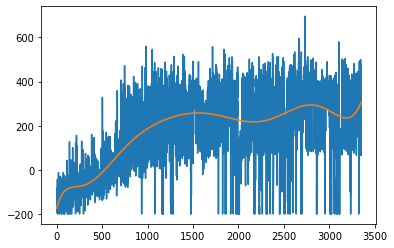

Episode : 3350/5000, Score : 104.0, Exploration : 4%
Episode : 3351/5000, Score : 356.0, Exploration : 3%
Episode : 3352/5000, Score : 371.0, Exploration : 3%
Episode : 3353/5000, Score : 356.0, Exploration : 3%
Episode : 3354/5000, Score : 290.0, Exploration : 3%
Episode : 3355/5000, Score : 277.0, Exploration : 3%
Episode : 3356/5000, Score : 375.0, Exploration : 3%
Episode : 3357/5000, Score : 80.0, Exploration : 3%
Episode : 3358/5000, Score : 154.0, Exploration : 3%
Episode : 3359/5000, Score : 331.0, Exploration : 3%
Episode : 3360/5000, Score : 82.0, Exploration : 3%
Episode : 3361/5000, Score : 98.0, Exploration : 3%
Episode : 3362/5000, Score : 146.0, Exploration : 3%
Episode : 3363/5000, Score : 78.0, Exploration : 3%
Episode : 3364/5000, Score : 142.0, Exploration : 3%
Episode : 3365/5000, Score : 76.0, Exploration : 3%
Episode : 3366/5000, Score : 410.0, Exploration : 3%
Episode : 3367/5000, Score : 468.0, Exploration : 3%
Episode : 3368/5000, Score : 278.0, Exploration : 3

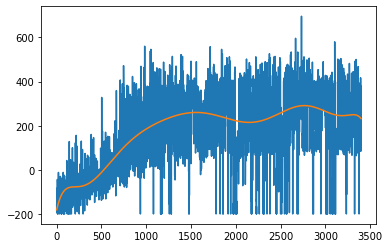

Episode : 3400/5000, Score : 321.0, Exploration : 3%
Episode : 3401/5000, Score : 365.0, Exploration : 3%
Episode : 3402/5000, Score : 325.0, Exploration : 3%
Episode : 3403/5000, Score : 456.0, Exploration : 3%
Episode : 3404/5000, Score : 327.0, Exploration : 3%
Episode : 3405/5000, Score : 114.0, Exploration : 3%
Episode : 3406/5000, Score : 408.0, Exploration : 3%
Episode : 3407/5000, Score : 120.0, Exploration : 3%
Episode : 3408/5000, Score : 328.0, Exploration : 3%
Episode : 3409/5000, Score : 266.0, Exploration : 3%
Episode : 3410/5000, Score : 297.0, Exploration : 3%
Episode : 3411/5000, Score : 66.0, Exploration : 3%
Episode : 3412/5000, Score : 253.0, Exploration : 3%
Episode : 3413/5000, Score : 312.0, Exploration : 3%
Episode : 3414/5000, Score : 323.0, Exploration : 3%
Episode : 3415/5000, Score : 318.0, Exploration : 3%
Episode : 3416/5000, Score : 78.0, Exploration : 3%
Episode : 3417/5000, Score : 152.0, Exploration : 3%
Episode : 3418/5000, Score : 443.0, Exploration 

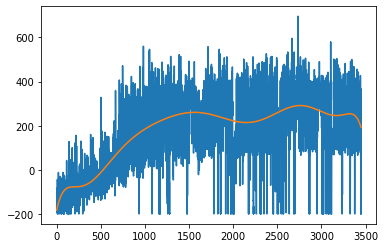

Episode : 3450/5000, Score : 268.0, Exploration : 3%
Episode : 3451/5000, Score : 309.0, Exploration : 3%
Episode : 3452/5000, Score : 90.0, Exploration : 3%
Episode : 3453/5000, Score : 256.0, Exploration : 3%
Episode : 3454/5000, Score : 228.0, Exploration : 3%
Episode : 3455/5000, Score : 344.0, Exploration : 3%
Episode : 3456/5000, Score : 88.0, Exploration : 3%
Episode : 3457/5000, Score : 156.0, Exploration : 3%
Episode : 3458/5000, Score : 118.0, Exploration : 3%
Episode : 3459/5000, Score : 352.0, Exploration : 3%
Episode : 3460/5000, Score : 140.0, Exploration : 3%
Episode : 3461/5000, Score : 218.0, Exploration : 3%
Episode : 3462/5000, Score : 224.0, Exploration : 3%
Episode : 3463/5000, Score : 128.0, Exploration : 3%
Episode : 3464/5000, Score : 130.0, Exploration : 3%
Episode : 3465/5000, Score : 340.0, Exploration : 3%
Episode : 3466/5000, Score : 368.0, Exploration : 3%
Episode : 3467/5000, Score : 293.0, Exploration : 3%
Episode : 3468/5000, Score : 286.0, Exploration 

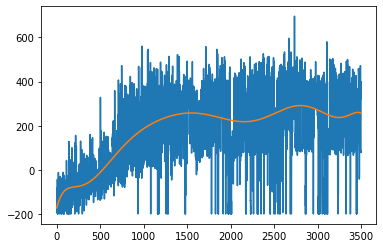

Episode : 3500/5000, Score : 342.0, Exploration : 3%
Episode : 3501/5000, Score : 454.0, Exploration : 3%
Episode : 3502/5000, Score : 246.0, Exploration : 3%
Episode : 3503/5000, Score : 317.0, Exploration : 3%
Episode : 3504/5000, Score : 423.0, Exploration : 3%
Episode : 3505/5000, Score : 349.0, Exploration : 3%
Episode : 3506/5000, Score : 404.0, Exploration : 3%
Episode : 3507/5000, Score : 94.0, Exploration : 3%
Episode : 3508/5000, Score : 445.0, Exploration : 3%
Episode : 3509/5000, Score : 375.0, Exploration : 3%
Episode : 3510/5000, Score : 450.0, Exploration : 3%
Episode : 3511/5000, Score : 74.0, Exploration : 3%
Episode : 3512/5000, Score : 428.0, Exploration : 3%
Episode : 3513/5000, Score : 422.0, Exploration : 3%
Episode : 3514/5000, Score : 110.0, Exploration : 3%
Episode : 3515/5000, Score : 448.0, Exploration : 3%
Episode : 3516/5000, Score : 236.0, Exploration : 3%
Episode : 3517/5000, Score : 204.0, Exploration : 3%
Episode : 3518/5000, Score : 356.0, Exploration 

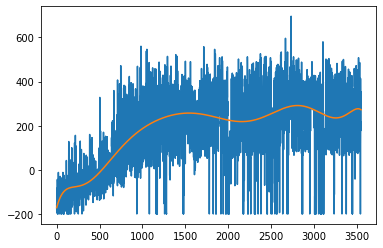

Episode : 3550/5000, Score : 146.0, Exploration : 3%
Episode : 3551/5000, Score : 86.0, Exploration : 3%
Episode : 3552/5000, Score : 160.0, Exploration : 3%
Episode : 3553/5000, Score : 236.0, Exploration : 3%
Episode : 3554/5000, Score : 170.0, Exploration : 3%
Episode : 3555/5000, Score : 354.0, Exploration : 3%
Episode : 3556/5000, Score : 270.0, Exploration : 3%
Episode : 3557/5000, Score : 416.0, Exploration : 3%
Episode : 3558/5000, Score : 350.0, Exploration : 3%
Episode : 3559/5000, Score : 348.0, Exploration : 3%
Episode : 3560/5000, Score : 174.0, Exploration : 3%
Episode : 3561/5000, Score : 402.0, Exploration : 3%
Episode : 3562/5000, Score : 362.0, Exploration : 3%
Episode : 3563/5000, Score : 314.0, Exploration : 3%
Episode : 3564/5000, Score : 426.0, Exploration : 3%
Episode : 3565/5000, Score : 436.0, Exploration : 3%
Episode : 3566/5000, Score : 448.0, Exploration : 3%
Episode : 3567/5000, Score : 330.0, Exploration : 3%
Episode : 3568/5000, Score : 394.0, Exploration

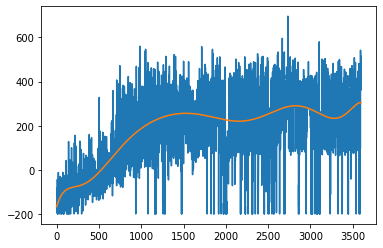

Episode : 3600/5000, Score : 301.0, Exploration : 3%
Episode : 3601/5000, Score : 363.0, Exploration : 3%
Episode : 3602/5000, Score : 295.0, Exploration : 3%
Episode : 3603/5000, Score : 305.0, Exploration : 3%
Episode : 3604/5000, Score : 313.0, Exploration : 3%
Episode : 3605/5000, Score : 177.0, Exploration : 3%
Episode : 3606/5000, Score : 314.0, Exploration : 3%
Episode : 3607/5000, Score : 367.0, Exploration : 3%
Episode : 3608/5000, Score : 351.0, Exploration : 3%
Episode : 3609/5000, Score : 92.0, Exploration : 3%
Episode : 3610/5000, Score : 370.0, Exploration : 3%
Episode : 3611/5000, Score : 422.0, Exploration : 3%
Episode : 3612/5000, Score : 354.0, Exploration : 3%
Episode : 3613/5000, Score : 325.0, Exploration : 3%
Episode : 3614/5000, Score : -200.0, Exploration : 3%
Episode : 3615/5000, Score : 358.0, Exploration : 3%
Episode : 3616/5000, Score : 386.0, Exploration : 3%
Episode : 3617/5000, Score : 216.0, Exploration : 3%
Episode : 3618/5000, Score : 244.0, Exploratio

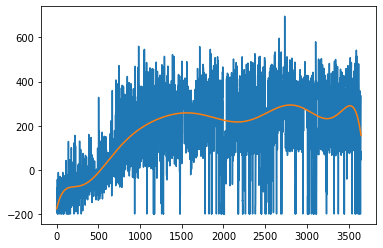

Episode : 3650/5000, Score : 430.0, Exploration : 3%
Episode : 3651/5000, Score : 404.0, Exploration : 3%
Episode : 3652/5000, Score : 406.0, Exploration : 3%
Episode : 3653/5000, Score : 408.0, Exploration : 3%
Episode : 3654/5000, Score : 374.0, Exploration : 3%
Episode : 3655/5000, Score : 412.0, Exploration : 3%
Episode : 3656/5000, Score : 479.0, Exploration : 3%
Episode : 3657/5000, Score : 443.0, Exploration : 3%
Episode : 3658/5000, Score : 374.0, Exploration : 3%
Episode : 3659/5000, Score : 435.0, Exploration : 3%
Episode : 3660/5000, Score : 341.0, Exploration : 3%
Episode : 3661/5000, Score : 332.0, Exploration : 3%
Episode : 3662/5000, Score : 312.0, Exploration : 3%
Episode : 3663/5000, Score : 424.0, Exploration : 3%
Episode : 3664/5000, Score : 390.0, Exploration : 3%
Episode : 3665/5000, Score : 378.0, Exploration : 3%
Episode : 3666/5000, Score : 382.0, Exploration : 3%
Episode : 3667/5000, Score : 382.0, Exploration : 3%
Episode : 3668/5000, Score : 392.0, Exploratio

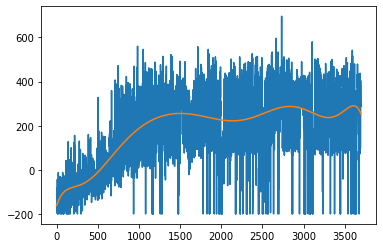

Episode : 3700/5000, Score : 372.0, Exploration : 2%
Episode : 3701/5000, Score : 626.0, Exploration : 2%
Episode : 3702/5000, Score : 324.0, Exploration : 2%
Episode : 3703/5000, Score : 418.0, Exploration : 2%
Episode : 3704/5000, Score : 408.0, Exploration : 2%
Episode : 3705/5000, Score : 430.0, Exploration : 2%
Episode : 3706/5000, Score : 440.0, Exploration : 2%
Episode : 3707/5000, Score : 394.0, Exploration : 2%
Episode : 3708/5000, Score : 370.0, Exploration : 2%
Episode : 3709/5000, Score : 308.0, Exploration : 2%
Episode : 3710/5000, Score : 182.0, Exploration : 2%
Episode : 3711/5000, Score : 346.0, Exploration : 2%
Episode : 3712/5000, Score : 402.0, Exploration : 2%
Episode : 3713/5000, Score : 526.0, Exploration : 2%
Episode : 3714/5000, Score : 438.0, Exploration : 2%
Episode : 3715/5000, Score : 440.0, Exploration : 2%
Episode : 3716/5000, Score : 416.0, Exploration : 2%
Episode : 3717/5000, Score : 388.0, Exploration : 2%
Episode : 3718/5000, Score : 338.0, Exploratio

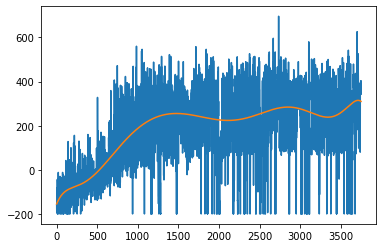

Episode : 3750/5000, Score : 321.0, Exploration : 2%
Episode : 3751/5000, Score : -200.0, Exploration : 2%
Episode : 3752/5000, Score : 162.0, Exploration : 2%
Episode : 3753/5000, Score : 413.0, Exploration : 2%
Episode : 3754/5000, Score : 360.0, Exploration : 2%
Episode : 3755/5000, Score : 374.0, Exploration : 2%
Episode : 3756/5000, Score : 353.0, Exploration : 2%
Episode : 3757/5000, Score : 473.0, Exploration : 2%
Episode : 3758/5000, Score : 446.0, Exploration : 2%
Episode : 3759/5000, Score : 338.0, Exploration : 2%
Episode : 3760/5000, Score : 421.0, Exploration : 2%
Episode : 3761/5000, Score : 449.0, Exploration : 2%
Episode : 3762/5000, Score : 371.0, Exploration : 2%
Episode : 3763/5000, Score : 494.0, Exploration : 2%
Episode : 3764/5000, Score : 341.0, Exploration : 2%
Episode : 3765/5000, Score : 464.0, Exploration : 2%
Episode : 3766/5000, Score : 446.0, Exploration : 2%
Episode : 3767/5000, Score : 486.0, Exploration : 2%
Episode : 3768/5000, Score : 390.0, Explorati

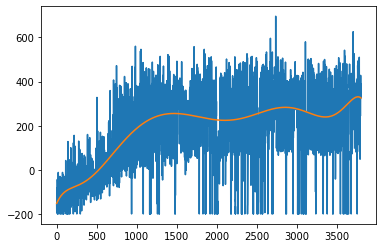

Episode : 3800/5000, Score : 326.0, Exploration : 2%
Episode : 3801/5000, Score : 342.0, Exploration : 2%
Episode : 3802/5000, Score : 326.0, Exploration : 2%
Episode : 3803/5000, Score : 474.0, Exploration : 2%
Episode : 3804/5000, Score : 510.0, Exploration : 2%
Episode : 3805/5000, Score : 380.0, Exploration : 2%
Episode : 3806/5000, Score : 410.0, Exploration : 2%
Episode : 3807/5000, Score : 372.0, Exploration : 2%
Episode : 3808/5000, Score : 374.0, Exploration : 2%
Episode : 3809/5000, Score : 282.0, Exploration : 2%
Episode : 3810/5000, Score : 494.0, Exploration : 2%
Episode : 3811/5000, Score : 432.0, Exploration : 2%
Episode : 3812/5000, Score : 384.0, Exploration : 2%
Episode : 3813/5000, Score : 335.0, Exploration : 2%
Episode : 3814/5000, Score : 289.0, Exploration : 2%
Episode : 3815/5000, Score : 344.0, Exploration : 2%
Episode : 3816/5000, Score : 375.0, Exploration : 2%
Episode : 3817/5000, Score : 283.0, Exploration : 2%
Episode : 3818/5000, Score : 104.0, Exploratio

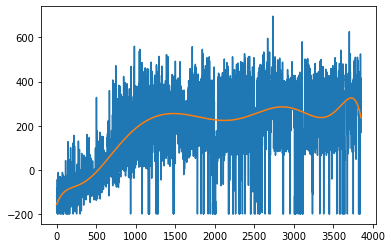

Episode : 3850/5000, Score : 488.0, Exploration : 2%
Episode : 3851/5000, Score : 422.0, Exploration : 2%
Episode : 3852/5000, Score : 568.0, Exploration : 2%
Episode : 3853/5000, Score : 400.0, Exploration : 2%
Episode : 3854/5000, Score : 361.0, Exploration : 2%
Episode : 3855/5000, Score : 396.0, Exploration : 2%
Episode : 3856/5000, Score : 398.0, Exploration : 2%
Episode : 3857/5000, Score : 344.0, Exploration : 2%
Episode : 3858/5000, Score : 470.0, Exploration : 2%
Episode : 3859/5000, Score : 435.0, Exploration : 2%
Episode : 3860/5000, Score : 423.0, Exploration : 2%
Episode : 3861/5000, Score : 372.0, Exploration : 2%
Episode : 3862/5000, Score : 410.0, Exploration : 2%
Episode : 3863/5000, Score : 367.0, Exploration : 2%
Episode : 3864/5000, Score : 374.0, Exploration : 2%
Episode : 3865/5000, Score : 329.0, Exploration : 2%
Episode : 3866/5000, Score : 348.0, Exploration : 2%
Episode : 3867/5000, Score : 273.0, Exploration : 2%
Episode : 3868/5000, Score : 282.0, Exploratio

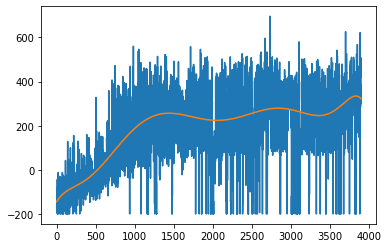

Episode : 3900/5000, Score : 384.0, Exploration : 2%
Episode : 3901/5000, Score : 386.0, Exploration : 2%
Episode : 3902/5000, Score : 454.0, Exploration : 2%
Episode : 3903/5000, Score : 504.0, Exploration : 2%
Episode : 3904/5000, Score : 444.0, Exploration : 2%
Episode : 3905/5000, Score : 395.0, Exploration : 2%
Episode : 3906/5000, Score : 392.0, Exploration : 2%
Episode : 3907/5000, Score : 154.0, Exploration : 2%
Episode : 3908/5000, Score : 2.0, Exploration : 2%
Episode : 3909/5000, Score : 278.0, Exploration : 2%
Episode : 3910/5000, Score : 348.0, Exploration : 2%
Episode : 3911/5000, Score : 529.0, Exploration : 2%
Episode : 3912/5000, Score : 264.0, Exploration : 2%
Episode : 3913/5000, Score : 392.0, Exploration : 2%
Episode : 3914/5000, Score : 420.0, Exploration : 2%
Episode : 3915/5000, Score : -200.0, Exploration : 2%
Episode : 3916/5000, Score : 256.0, Exploration : 2%
Episode : 3917/5000, Score : 330.0, Exploration : 2%
Episode : 3918/5000, Score : 354.0, Exploration

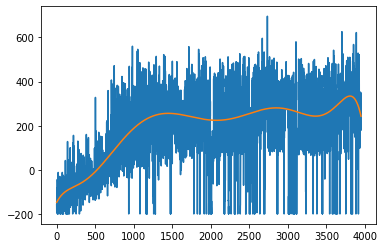

Episode : 3950/5000, Score : 188.0, Exploration : 2%
Episode : 3951/5000, Score : 194.0, Exploration : 2%
Episode : 3952/5000, Score : 132.0, Exploration : 2%
Episode : 3953/5000, Score : -200.0, Exploration : 2%
Episode : 3954/5000, Score : 314.0, Exploration : 2%
Episode : 3955/5000, Score : -200.0, Exploration : 2%
Episode : 3956/5000, Score : 132.0, Exploration : 2%
Episode : 3957/5000, Score : 306.0, Exploration : 2%
Episode : 3958/5000, Score : 321.0, Exploration : 2%
Episode : 3959/5000, Score : 171.0, Exploration : 2%
Episode : 3960/5000, Score : 378.0, Exploration : 2%
Episode : 3961/5000, Score : 256.0, Exploration : 2%
Episode : 3962/5000, Score : 348.0, Exploration : 2%
Episode : 3963/5000, Score : 274.0, Exploration : 2%
Episode : 3964/5000, Score : 262.0, Exploration : 2%
Episode : 3965/5000, Score : -200.0, Exploration : 2%
Episode : 3966/5000, Score : 26.0, Exploration : 2%
Episode : 3967/5000, Score : 130.0, Exploration : 2%
Episode : 3968/5000, Score : 88.0, Explorati

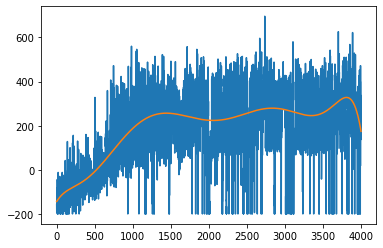

Episode : 4000/5000, Score : 327.0, Exploration : 2%
Episode : 4001/5000, Score : 284.0, Exploration : 2%
Episode : 4002/5000, Score : 266.0, Exploration : 2%
Episode : 4003/5000, Score : 458.0, Exploration : 2%
Episode : 4004/5000, Score : 364.0, Exploration : 2%
Episode : 4005/5000, Score : 354.0, Exploration : 2%
Episode : 4006/5000, Score : 414.0, Exploration : 2%
Episode : 4007/5000, Score : 312.0, Exploration : 2%
Episode : 4008/5000, Score : 408.0, Exploration : 2%
Episode : 4009/5000, Score : 542.0, Exploration : 2%
Episode : 4010/5000, Score : 396.0, Exploration : 2%
Episode : 4011/5000, Score : 364.0, Exploration : 2%
Episode : 4012/5000, Score : 326.0, Exploration : 2%
Episode : 4013/5000, Score : 104.0, Exploration : 2%
Episode : 4014/5000, Score : 404.0, Exploration : 2%
Episode : 4015/5000, Score : 366.0, Exploration : 2%
Episode : 4016/5000, Score : 344.0, Exploration : 2%
Episode : 4017/5000, Score : 406.0, Exploration : 2%
Episode : 4018/5000, Score : 368.0, Exploratio

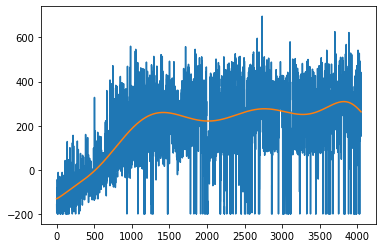

Episode : 4050/5000, Score : 356.0, Exploration : 2%
Episode : 4051/5000, Score : 90.0, Exploration : 2%
Episode : 4052/5000, Score : -200.0, Exploration : 2%
Episode : 4053/5000, Score : 440.0, Exploration : 2%
Episode : 4054/5000, Score : -200.0, Exploration : 2%
Episode : 4055/5000, Score : 576.0, Exploration : 2%
Episode : 4056/5000, Score : 380.0, Exploration : 2%
Episode : 4057/5000, Score : -200.0, Exploration : 2%
Episode : 4058/5000, Score : 278.0, Exploration : 2%
Episode : 4059/5000, Score : 172.0, Exploration : 2%
Episode : 4060/5000, Score : 90.0, Exploration : 2%
Episode : 4061/5000, Score : 272.0, Exploration : 2%
Episode : 4062/5000, Score : 398.0, Exploration : 2%
Episode : 4063/5000, Score : 382.0, Exploration : 2%
Episode : 4064/5000, Score : 142.0, Exploration : 2%
Episode : 4065/5000, Score : 180.0, Exploration : 2%
Episode : 4066/5000, Score : 84.0, Exploration : 2%
Episode : 4067/5000, Score : 390.0, Exploration : 2%
Episode : 4068/5000, Score : 406.0, Exploratio

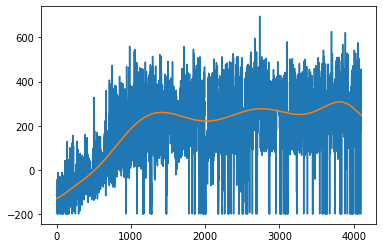

Episode : 4100/5000, Score : 351.0, Exploration : 2%
Episode : 4101/5000, Score : -200.0, Exploration : 2%
Episode : 4102/5000, Score : 338.0, Exploration : 2%
Episode : 4103/5000, Score : -200.0, Exploration : 2%
Episode : 4104/5000, Score : 238.0, Exploration : 2%
Episode : 4105/5000, Score : -200.0, Exploration : 2%
Episode : 4106/5000, Score : 358.0, Exploration : 2%
Episode : 4107/5000, Score : 381.0, Exploration : 2%
Episode : 4108/5000, Score : 378.0, Exploration : 2%
Episode : 4109/5000, Score : 153.0, Exploration : 2%
Episode : 4110/5000, Score : 329.0, Exploration : 2%
Episode : 4111/5000, Score : 315.0, Exploration : 2%
Episode : 4112/5000, Score : 287.0, Exploration : 2%
Episode : 4113/5000, Score : -56.0, Exploration : 2%
Episode : 4114/5000, Score : -200.0, Exploration : 2%
Episode : 4115/5000, Score : 183.0, Exploration : 2%
Episode : 4116/5000, Score : 246.0, Exploration : 2%
Episode : 4117/5000, Score : 171.0, Exploration : 2%
Episode : 4118/5000, Score : 338.0, Explor

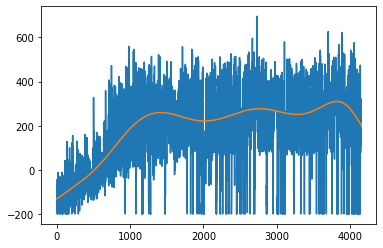

Episode : 4150/5000, Score : 308.0, Exploration : 2%
Episode : 4151/5000, Score : 371.0, Exploration : 2%
Episode : 4152/5000, Score : 350.0, Exploration : 2%
Episode : 4153/5000, Score : 356.0, Exploration : 2%
Episode : 4154/5000, Score : 319.0, Exploration : 2%
Episode : 4155/5000, Score : 437.0, Exploration : 2%
Episode : 4156/5000, Score : 174.0, Exploration : 2%
Episode : 4157/5000, Score : 409.0, Exploration : 2%
Episode : 4158/5000, Score : 172.0, Exploration : 2%
Episode : 4159/5000, Score : 208.0, Exploration : 2%
Episode : 4160/5000, Score : 488.0, Exploration : 2%
Episode : 4161/5000, Score : 184.0, Exploration : 2%
Episode : 4162/5000, Score : 84.0, Exploration : 2%
Episode : 4163/5000, Score : 368.0, Exploration : 2%
Episode : 4164/5000, Score : 360.0, Exploration : 2%
Episode : 4165/5000, Score : 356.0, Exploration : 2%
Episode : 4166/5000, Score : 274.0, Exploration : 2%
Episode : 4167/5000, Score : 198.0, Exploration : 2%
Episode : 4168/5000, Score : 238.0, Exploration

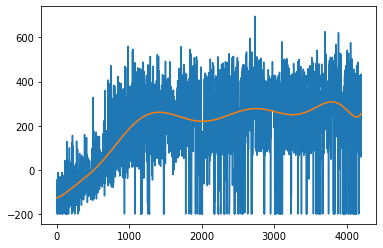

Episode : 4200/5000, Score : 88.0, Exploration : 1%
Episode : 4201/5000, Score : 442.0, Exploration : 1%
Episode : 4202/5000, Score : 357.0, Exploration : 1%
Episode : 4203/5000, Score : 454.0, Exploration : 1%
Episode : 4204/5000, Score : 170.0, Exploration : 1%
Episode : 4205/5000, Score : 94.0, Exploration : 1%
Episode : 4206/5000, Score : 102.0, Exploration : 1%
Episode : 4207/5000, Score : 409.0, Exploration : 1%
Episode : 4208/5000, Score : 349.0, Exploration : 1%
Episode : 4209/5000, Score : 382.0, Exploration : 1%
Episode : 4210/5000, Score : 86.0, Exploration : 1%
Episode : 4211/5000, Score : 98.0, Exploration : 1%
Episode : 4212/5000, Score : 212.0, Exploration : 1%
Episode : 4213/5000, Score : 34.0, Exploration : 1%
Episode : 4214/5000, Score : 22.0, Exploration : 1%
Episode : 4215/5000, Score : 158.0, Exploration : 1%
Episode : 4216/5000, Score : 384.0, Exploration : 1%
Episode : 4217/5000, Score : 326.0, Exploration : 1%
Episode : 4218/5000, Score : 315.0, Exploration : 1%

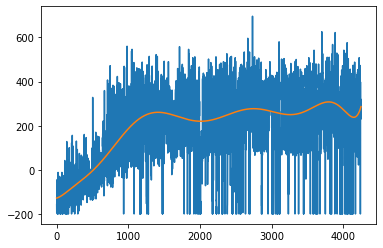

Episode : 4250/5000, Score : 312.0, Exploration : 1%
Episode : 4251/5000, Score : 518.0, Exploration : 1%
Episode : 4252/5000, Score : 420.0, Exploration : 1%
Episode : 4253/5000, Score : 126.0, Exploration : 1%
Episode : 4254/5000, Score : 82.0, Exploration : 1%
Episode : 4255/5000, Score : 332.0, Exploration : 1%
Episode : 4256/5000, Score : 384.0, Exploration : 1%
Episode : 4257/5000, Score : 320.0, Exploration : 1%
Episode : 4258/5000, Score : 108.0, Exploration : 1%
Episode : 4259/5000, Score : 168.0, Exploration : 1%
Episode : 4260/5000, Score : 431.0, Exploration : 1%
Episode : 4261/5000, Score : 414.0, Exploration : 1%
Episode : 4262/5000, Score : 462.0, Exploration : 1%
Episode : 4263/5000, Score : 359.0, Exploration : 1%
Episode : 4264/5000, Score : 377.0, Exploration : 1%
Episode : 4265/5000, Score : 410.0, Exploration : 1%
Episode : 4266/5000, Score : 436.0, Exploration : 1%
Episode : 4267/5000, Score : 380.0, Exploration : 1%
Episode : 4268/5000, Score : 376.0, Exploration

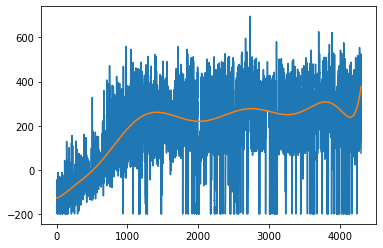

Episode : 4300/5000, Score : 76.0, Exploration : 1%
Episode : 4301/5000, Score : 144.0, Exploration : 1%
Episode : 4302/5000, Score : 510.0, Exploration : 1%
Episode : 4303/5000, Score : 106.0, Exploration : 1%
Episode : 4304/5000, Score : 438.0, Exploration : 1%
Episode : 4305/5000, Score : 84.0, Exploration : 1%
Episode : 4306/5000, Score : 324.0, Exploration : 1%
Episode : 4307/5000, Score : 326.0, Exploration : 1%
Episode : 4308/5000, Score : -200.0, Exploration : 1%
Episode : 4309/5000, Score : 294.0, Exploration : 1%
Episode : 4310/5000, Score : 266.0, Exploration : 1%
Episode : 4311/5000, Score : 124.0, Exploration : 1%
Episode : 4312/5000, Score : 172.0, Exploration : 1%
Episode : 4313/5000, Score : 214.0, Exploration : 1%
Episode : 4314/5000, Score : 304.0, Exploration : 1%
Episode : 4315/5000, Score : 376.0, Exploration : 1%
Episode : 4316/5000, Score : 228.0, Exploration : 1%
Episode : 4317/5000, Score : 88.0, Exploration : 1%
Episode : 4318/5000, Score : 374.0, Exploration 

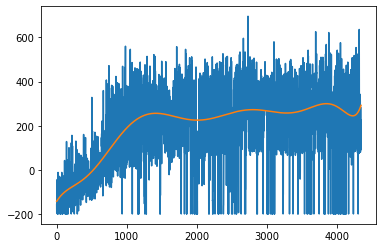

Episode : 4350/5000, Score : 42.0, Exploration : 1%
Episode : 4351/5000, Score : 118.0, Exploration : 1%
Episode : 4352/5000, Score : 126.0, Exploration : 1%
Episode : 4353/5000, Score : 184.0, Exploration : 1%
Episode : 4354/5000, Score : 174.0, Exploration : 1%
Episode : 4355/5000, Score : 204.0, Exploration : 1%
Episode : 4356/5000, Score : 106.0, Exploration : 1%
Episode : 4357/5000, Score : 178.0, Exploration : 1%
Episode : 4358/5000, Score : 86.0, Exploration : 1%
Episode : 4359/5000, Score : 74.0, Exploration : 1%
Episode : 4360/5000, Score : 80.0, Exploration : 1%
Episode : 4361/5000, Score : 158.0, Exploration : 1%
Episode : 4362/5000, Score : 162.0, Exploration : 1%
Episode : 4363/5000, Score : 423.0, Exploration : 1%
Episode : 4364/5000, Score : 132.0, Exploration : 1%
Episode : 4365/5000, Score : 158.0, Exploration : 1%
Episode : 4366/5000, Score : 120.0, Exploration : 1%
Episode : 4367/5000, Score : 142.0, Exploration : 1%
Episode : 4368/5000, Score : 138.0, Exploration : 

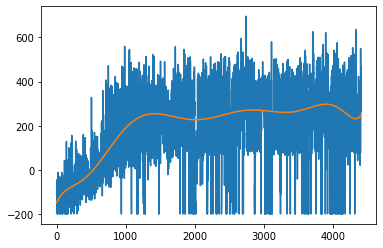

Episode : 4400/5000, Score : 290.0, Exploration : 1%
Episode : 4401/5000, Score : 335.0, Exploration : 1%
Episode : 4402/5000, Score : 142.0, Exploration : 1%
Episode : 4403/5000, Score : 354.0, Exploration : 1%
Episode : 4404/5000, Score : 96.0, Exploration : 1%
Episode : 4405/5000, Score : 351.0, Exploration : 1%
Episode : 4406/5000, Score : 347.0, Exploration : 1%
Episode : 4407/5000, Score : 542.0, Exploration : 1%
Episode : 4408/5000, Score : -200.0, Exploration : 1%
Episode : 4409/5000, Score : -200.0, Exploration : 1%
Episode : 4410/5000, Score : -200.0, Exploration : 1%
Episode : 4411/5000, Score : 268.0, Exploration : 1%
Episode : 4412/5000, Score : 286.0, Exploration : 1%
Episode : 4413/5000, Score : 335.0, Exploration : 1%
Episode : 4414/5000, Score : 224.0, Exploration : 1%
Episode : 4415/5000, Score : 84.0, Exploration : 1%
Episode : 4416/5000, Score : 376.0, Exploration : 1%
Episode : 4417/5000, Score : 82.0, Exploration : 1%
Episode : 4418/5000, Score : 126.0, Exploratio

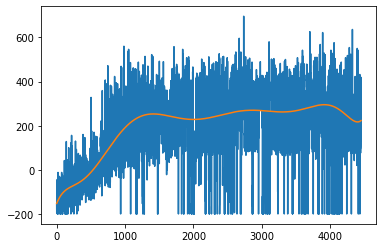

Episode : 4450/5000, Score : 82.0, Exploration : 1%
Episode : 4451/5000, Score : 74.0, Exploration : 1%
Episode : 4452/5000, Score : 362.0, Exploration : 1%
Episode : 4453/5000, Score : 338.0, Exploration : 1%
Episode : 4454/5000, Score : 422.0, Exploration : 1%
Episode : 4455/5000, Score : 404.0, Exploration : 1%
Episode : 4456/5000, Score : 516.0, Exploration : 1%
Episode : 4457/5000, Score : 366.0, Exploration : 1%
Episode : 4458/5000, Score : 116.0, Exploration : 1%
Episode : 4459/5000, Score : 422.0, Exploration : 1%
Episode : 4460/5000, Score : 396.0, Exploration : 1%
Episode : 4461/5000, Score : 146.0, Exploration : 1%
Episode : 4462/5000, Score : 418.0, Exploration : 1%
Episode : 4463/5000, Score : 460.0, Exploration : 1%
Episode : 4464/5000, Score : 385.0, Exploration : 1%
Episode : 4465/5000, Score : 419.0, Exploration : 1%
Episode : 4466/5000, Score : 74.0, Exploration : 1%
Episode : 4467/5000, Score : 444.0, Exploration : 1%
Episode : 4468/5000, Score : 439.0, Exploration :

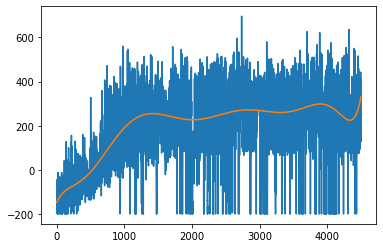

Episode : 4500/5000, Score : 98.0, Exploration : 1%
Episode : 4501/5000, Score : 380.0, Exploration : 1%
Episode : 4502/5000, Score : 84.0, Exploration : 1%
Episode : 4503/5000, Score : 465.0, Exploration : 1%
Episode : 4504/5000, Score : 86.0, Exploration : 1%
Episode : 4505/5000, Score : 218.0, Exploration : 1%
Episode : 4506/5000, Score : 412.0, Exploration : 1%
Episode : 4507/5000, Score : 382.0, Exploration : 1%
Episode : 4508/5000, Score : 225.0, Exploration : 1%
Episode : 4509/5000, Score : 194.0, Exploration : 1%
Episode : 4510/5000, Score : 154.0, Exploration : 1%
Episode : 4511/5000, Score : 142.0, Exploration : 1%
Episode : 4512/5000, Score : 398.0, Exploration : 1%
Episode : 4513/5000, Score : -200.0, Exploration : 1%
Episode : 4514/5000, Score : 224.0, Exploration : 1%
Episode : 4515/5000, Score : 196.0, Exploration : 1%
Episode : 4516/5000, Score : 204.0, Exploration : 1%
Episode : 4517/5000, Score : 306.0, Exploration : 1%
Episode : 4518/5000, Score : 436.0, Exploration 

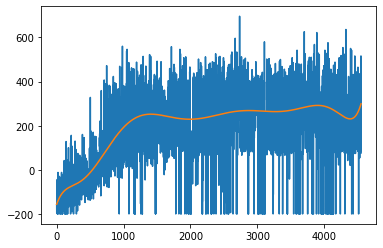

Episode : 4550/5000, Score : 516.0, Exploration : 1%
Episode : 4551/5000, Score : 354.0, Exploration : 1%
Episode : 4552/5000, Score : 361.0, Exploration : 1%
Episode : 4553/5000, Score : -200.0, Exploration : 1%
Episode : 4554/5000, Score : 156.0, Exploration : 1%
Episode : 4555/5000, Score : 262.0, Exploration : 1%
Episode : 4556/5000, Score : 176.0, Exploration : 1%
Episode : 4557/5000, Score : 148.0, Exploration : 1%
Episode : 4558/5000, Score : 150.0, Exploration : 1%
Episode : 4559/5000, Score : 88.0, Exploration : 1%
Episode : 4560/5000, Score : 250.0, Exploration : 1%
Episode : 4561/5000, Score : 190.0, Exploration : 1%
Episode : 4562/5000, Score : 292.0, Exploration : 1%
Episode : 4563/5000, Score : 104.0, Exploration : 1%
Episode : 4564/5000, Score : 110.0, Exploration : 1%
Episode : 4565/5000, Score : 323.0, Exploration : 1%
Episode : 4566/5000, Score : 142.0, Exploration : 1%
Episode : 4567/5000, Score : 172.0, Exploration : 1%
Episode : 4568/5000, Score : 114.0, Exploratio

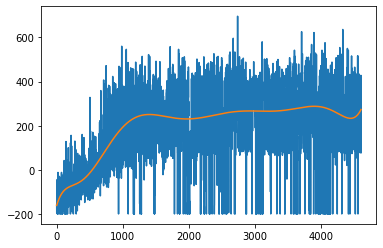

Episode : 4600/5000, Score : 414.0, Exploration : 1%
Episode : 4601/5000, Score : 278.0, Exploration : 1%
Episode : 4602/5000, Score : 426.0, Exploration : 1%
Episode : 4603/5000, Score : 292.0, Exploration : 1%
Episode : 4604/5000, Score : 342.0, Exploration : 1%
Episode : 4605/5000, Score : 428.0, Exploration : 1%
Episode : 4606/5000, Score : 426.0, Exploration : 1%
Episode : 4607/5000, Score : 340.0, Exploration : 1%
Episode : 4608/5000, Score : 400.0, Exploration : 1%
Episode : 4609/5000, Score : 422.0, Exploration : 1%
Episode : 4610/5000, Score : 108.0, Exploration : 1%
Episode : 4611/5000, Score : 238.0, Exploration : 1%
Episode : 4612/5000, Score : -200.0, Exploration : 1%
Episode : 4613/5000, Score : 356.0, Exploration : 1%
Episode : 4614/5000, Score : 390.0, Exploration : 1%
Episode : 4615/5000, Score : 502.0, Exploration : 1%
Episode : 4616/5000, Score : 462.0, Exploration : 1%
Episode : 4617/5000, Score : 116.0, Exploration : 1%
Episode : 4618/5000, Score : 126.0, Explorati

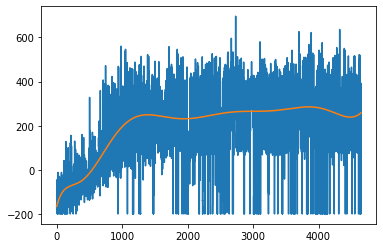

Episode : 4650/5000, Score : 170.0, Exploration : 1%
Episode : 4651/5000, Score : 306.0, Exploration : 1%
Episode : 4652/5000, Score : 228.0, Exploration : 1%
Episode : 4653/5000, Score : 328.0, Exploration : 1%
Episode : 4654/5000, Score : 152.0, Exploration : 1%
Episode : 4655/5000, Score : 212.0, Exploration : 1%
Episode : 4656/5000, Score : 76.0, Exploration : 1%
Episode : 4657/5000, Score : 94.0, Exploration : 1%
Episode : 4658/5000, Score : 166.0, Exploration : 1%
Episode : 4659/5000, Score : 200.0, Exploration : 1%
Episode : 4660/5000, Score : 90.0, Exploration : 1%
Episode : 4661/5000, Score : 98.0, Exploration : 1%
Episode : 4662/5000, Score : 152.0, Exploration : 1%
Episode : 4663/5000, Score : 176.0, Exploration : 1%
Episode : 4664/5000, Score : 88.0, Exploration : 1%
Episode : 4665/5000, Score : 106.0, Exploration : 1%
Episode : 4666/5000, Score : 374.0, Exploration : 1%
Episode : 4667/5000, Score : 320.0, Exploration : 1%
Episode : 4668/5000, Score : 186.0, Exploration : 1

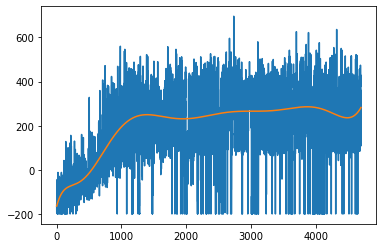

Episode : 4700/5000, Score : 368.0, Exploration : 1%
Episode : 4701/5000, Score : 374.0, Exploration : 1%
Episode : 4702/5000, Score : 358.0, Exploration : 1%
Episode : 4703/5000, Score : 392.0, Exploration : 1%
Episode : 4704/5000, Score : 510.0, Exploration : 1%
Episode : 4705/5000, Score : 398.0, Exploration : 1%
Episode : 4706/5000, Score : 488.0, Exploration : 1%
Episode : 4707/5000, Score : 380.0, Exploration : 1%
Episode : 4708/5000, Score : 486.0, Exploration : 1%
Episode : 4709/5000, Score : 440.0, Exploration : 1%
Episode : 4710/5000, Score : 324.0, Exploration : 1%
Episode : 4711/5000, Score : 340.0, Exploration : 1%
Episode : 4712/5000, Score : 342.0, Exploration : 1%
Episode : 4713/5000, Score : 294.0, Exploration : 1%
Episode : 4714/5000, Score : 150.0, Exploration : 1%
Episode : 4715/5000, Score : 106.0, Exploration : 1%
Episode : 4716/5000, Score : 100.0, Exploration : 1%
Episode : 4717/5000, Score : 218.0, Exploration : 1%
Episode : 4718/5000, Score : 124.0, Exploratio

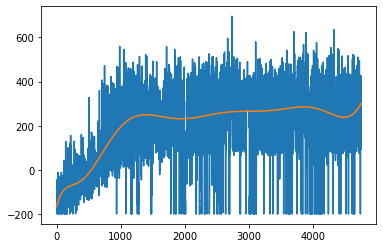

Episode : 4750/5000, Score : 282.0, Exploration : 1%
Episode : 4751/5000, Score : 193.0, Exploration : 1%
Episode : 4752/5000, Score : 267.0, Exploration : 1%
Episode : 4753/5000, Score : 100.0, Exploration : 1%
Episode : 4754/5000, Score : 259.0, Exploration : 1%
Episode : 4755/5000, Score : 293.0, Exploration : 1%
Episode : 4756/5000, Score : 204.0, Exploration : 1%
Episode : 4757/5000, Score : -200.0, Exploration : 1%
Episode : 4758/5000, Score : 194.0, Exploration : 1%
Episode : 4759/5000, Score : 96.0, Exploration : 1%
Episode : 4760/5000, Score : 284.0, Exploration : 1%
Episode : 4761/5000, Score : 339.0, Exploration : 1%
Episode : 4762/5000, Score : 358.0, Exploration : 1%
Episode : 4763/5000, Score : 100.0, Exploration : 1%
Episode : 4764/5000, Score : 404.0, Exploration : 1%
Episode : 4765/5000, Score : 449.0, Exploration : 1%
Episode : 4766/5000, Score : 378.0, Exploration : 1%
Episode : 4767/5000, Score : 300.0, Exploration : 1%
Episode : 4768/5000, Score : 383.0, Exploratio

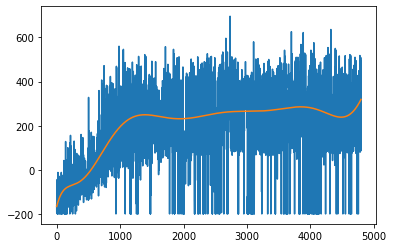

Episode : 4800/5000, Score : 162.0, Exploration : 1%
Episode : 4801/5000, Score : 478.0, Exploration : 1%
Episode : 4802/5000, Score : 550.0, Exploration : 1%
Episode : 4803/5000, Score : 456.0, Exploration : 1%
Episode : 4804/5000, Score : 122.0, Exploration : 1%
Episode : 4805/5000, Score : 400.0, Exploration : 1%
Episode : 4806/5000, Score : 453.0, Exploration : 1%
Episode : 4807/5000, Score : 416.0, Exploration : 1%
Episode : 4808/5000, Score : 395.0, Exploration : 1%
Episode : 4809/5000, Score : 120.0, Exploration : 1%
Episode : 4810/5000, Score : 337.0, Exploration : 1%
Episode : 4811/5000, Score : 448.0, Exploration : 1%
Episode : 4812/5000, Score : 102.0, Exploration : 1%
Episode : 4813/5000, Score : 154.0, Exploration : 1%
Episode : 4814/5000, Score : 90.0, Exploration : 1%
Episode : 4815/5000, Score : 453.0, Exploration : 1%
Episode : 4816/5000, Score : 448.0, Exploration : 1%
Episode : 4817/5000, Score : 410.0, Exploration : 1%
Episode : 4818/5000, Score : 466.0, Exploration

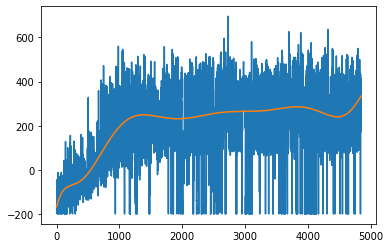

Episode : 4850/5000, Score : 74.0, Exploration : 1%
Episode : 4851/5000, Score : 382.0, Exploration : 1%
Episode : 4852/5000, Score : 178.0, Exploration : 1%
Episode : 4853/5000, Score : 82.0, Exploration : 1%
Episode : 4854/5000, Score : 452.0, Exploration : 1%
Episode : 4855/5000, Score : 532.0, Exploration : 1%
Episode : 4856/5000, Score : 404.0, Exploration : 1%
Episode : 4857/5000, Score : 351.0, Exploration : 1%
Episode : 4858/5000, Score : 368.0, Exploration : 1%
Episode : 4859/5000, Score : 414.0, Exploration : 1%
Episode : 4860/5000, Score : 402.0, Exploration : 1%
Episode : 4861/5000, Score : 402.0, Exploration : 1%
Episode : 4862/5000, Score : 456.0, Exploration : 1%
Episode : 4863/5000, Score : 114.0, Exploration : 1%
Episode : 4864/5000, Score : 214.0, Exploration : 1%
Episode : 4865/5000, Score : 364.0, Exploration : 1%
Episode : 4866/5000, Score : 363.0, Exploration : 1%
Episode : 4867/5000, Score : 182.0, Exploration : 1%
Episode : 4868/5000, Score : 150.0, Exploration 

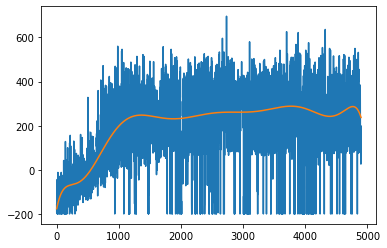

Episode : 4900/5000, Score : 388.0, Exploration : 1%
Episode : 4901/5000, Score : 324.0, Exploration : 1%
Episode : 4902/5000, Score : 106.0, Exploration : 1%
Episode : 4903/5000, Score : 100.0, Exploration : 1%
Episode : 4904/5000, Score : 186.0, Exploration : 1%
Episode : 4905/5000, Score : 152.0, Exploration : 1%
Episode : 4906/5000, Score : 180.0, Exploration : 1%
Episode : 4907/5000, Score : 188.0, Exploration : 1%
Episode : 4908/5000, Score : 96.0, Exploration : 1%
Episode : 4909/5000, Score : 82.0, Exploration : 1%
Episode : 4910/5000, Score : 108.0, Exploration : 1%
Episode : 4911/5000, Score : 146.0, Exploration : 1%
Episode : 4912/5000, Score : 118.0, Exploration : 1%
Episode : 4913/5000, Score : 312.0, Exploration : 1%
Episode : 4914/5000, Score : 64.0, Exploration : 1%
Episode : 4915/5000, Score : 342.0, Exploration : 1%
Episode : 4916/5000, Score : 422.0, Exploration : 1%
Episode : 4917/5000, Score : 354.0, Exploration : 1%
Episode : 4918/5000, Score : 582.0, Exploration :

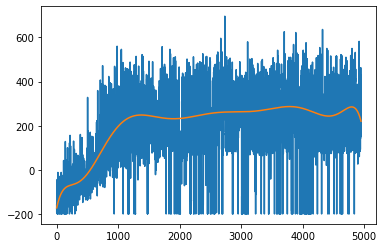

Episode : 4950/5000, Score : 182.0, Exploration : 1%
Episode : 4951/5000, Score : 368.0, Exploration : 1%
Episode : 4952/5000, Score : 446.0, Exploration : 1%
Episode : 4953/5000, Score : 430.0, Exploration : 1%
Episode : 4954/5000, Score : 402.0, Exploration : 1%
Episode : 4955/5000, Score : 342.0, Exploration : 1%
Episode : 4956/5000, Score : 426.0, Exploration : 1%
Episode : 4957/5000, Score : 416.0, Exploration : 1%
Episode : 4958/5000, Score : 140.0, Exploration : 1%
Episode : 4959/5000, Score : 324.0, Exploration : 1%
Episode : 4960/5000, Score : 353.0, Exploration : 1%
Episode : 4961/5000, Score : 484.0, Exploration : 1%
Episode : 4962/5000, Score : 208.0, Exploration : 1%
Episode : 4963/5000, Score : 194.0, Exploration : 1%
Episode : 4964/5000, Score : 336.0, Exploration : 1%
Episode : 4965/5000, Score : 524.0, Exploration : 1%
Episode : 4966/5000, Score : 376.0, Exploration : 1%
Episode : 4967/5000, Score : 578.0, Exploration : 1%
Episode : 4968/5000, Score : 346.0, Exploratio

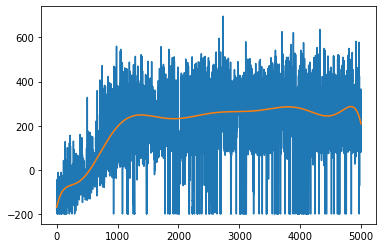

In [ ]:
# On fixe le nombre de parties désirées
episodes = 5000
scores = []

for e in range(episodes):

  # Initialisation de l'environnement (à chaque partie)
  observation = env.reset().reshape([1, dim_observations])
  score = 0

  # Début d'une partie
  for i in range(200):

    # Choisir une action : aléatoire ou prédite par le réseau de neurones
    # La part d'ations prédites augmente avec l'avancement de l'entraînement
    # Le but étant d'éviter que l'agent (la voiture) ne se focalise sur une éventuelle solution sub-optimale
    if np.random.sample() < epsilon:
      action = env.action_space.sample()
    else:
      action = np.argmax(model.predict(observation)[0])

    # Effectuer l'action et récupérer les nouvelles informations dooné par l'environement
    nouvelle_observation, reward, done, _ = env.step(action)

    # Modélisation de la récompense en fonction de la position de la voiture
    # Cela permet d'aider le modèle à bien s'entraîner

    if nouvelle_observation[0] <= -0.6 and nouvelle_observation[0] > -0.8:
      reward += 2
    elif nouvelle_observation[0] <= -0.8 and nouvelle_observation[0] > -1:
      reward += 4
    elif nouvelle_observation[0] <= -1:
      reward += 8
    elif nouvelle_observation[0] >= -0.3 and nouvelle_observation[0] < 0.0:
      reward += 2
    elif nouvelle_observation[0] >= 0.0 and nouvelle_observation[0] < 0.3:
      reward += 4
    elif nouvelle_observation[0] >= -0.3 and nouvelle_observation[0] < 0.5:
      reward += 8
    elif nouvelle_observation[0] >= 0.5:
      reward += 16

    nouvelle_observation = nouvelle_observation.reshape([1, dim_observations])

    # On mémorise l'ancienne observation, l'action choisie, la récompense obtenue,  et la nouvelle observation
    memory.append((observation, action, reward, done, nouvelle_observation))
    observation = nouvelle_observation

    # On additionne les reward afin de se constituer un score
    score += reward

    if done:
      # Fin de la partie (si on atteint le drapeau ou si l'on dépace le nombre d'actions autorisées par partie)
      break

  scores.append(score)

  print('Episode : {}/{}, Score : {}, Exploration : {:.0%}'.format(e, episodes, score, epsilon))

  # Entre chaque partie, on entraîne le réseau de neuronnes sur les expériences passées (stockées dans la memory)
  # Sélectionner des expériences aléatoirement dans la mémoire
  # On en sélectionne 48 (batch_size choisi)
  minibatch = random.sample(memory, batch_size)

  # Pour chaque expérience piocher dans le minibatch, on extrait les différents informations 
  for observation, action, reward, done, nouvelle_observation in minibatch:

    # Si le drapeau n'est n'est pas atteint, on utilise l'équation de Bellman
    # Cette section du code est développée dans le rapport
    if not done:
      cible = reward + discount_rate * np.amax(model.predict(nouvelle_observation)[0])
    else:
      cible = reward

    cible_f = model.predict(observation)
    cible_f[0][action] = cible

    model.fit(observation, cible_f, epochs = 1, verbose = 0)

  # On baisse le niveau d'exploration (part d'actions aléatoires) à chaque épisode
  if epsilon > epsilon_min:
    epsilon *= epsilon_decay

  # Toutes les 50 parties, on enregistre les poids du réseau de neurones (checkpoints)
  # Nous traçons également l'évolution des scores en fonction du nombre de parties
  if (e+1) % 50 == 0:
    model.save('/content/drive/My Drive/Colab Notebooks/DQN_Agent_MountainCar.h5')
    print('Le modèle est sauvegardé')

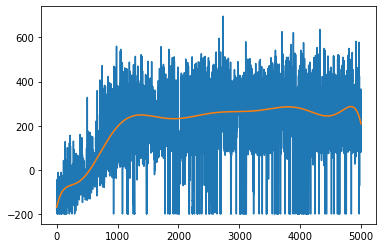

In [ ]:
X = range(len(scores))
Y = scores
reg = np.polyfit(X, Y, 10)
reg_coeff = np.poly1d(reg)
plt.plot(X, Y)
plt.plot(X, reg_coeff(X))
plt.show()